In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import itertools
import copy

In [2]:
PICKLES_ADDRESS = '../data/pickles/'
LAG_DATA_ADDRESS = 'lag_data/'
PUBMED_ADDRESS = '../data/pubmed_dataset/'
SBIR_ADDRESS = '../data/sbir_dataset/'

In [3]:
years = [str(year) for year in range(2010, 2022)]
correlation_lags = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7, 8, 9, 10, 11]

with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
with open(PICKLES_ADDRESS + 'heading2dui.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
with open(PICKLES_ADDRESS + 'level2duis.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
with open(PICKLES_ADDRESS + 'dui2level.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)

dui2name = {dui:heading for heading, dui in name2dui.items()}
dui_intersections = set(dui2children.keys()) & set(dui2parents.keys()) & set(dui2name.keys()) & set(dui2level.keys())

excluded_duis = [dui for dui in dui2children.keys() if dui not in dui_intersections]
excluded_duis += [dui for dui in dui2parents.keys() if dui not in dui_intersections]
excluded_duis += [dui for dui in dui2name.keys() if dui not in dui_intersections]
excluded_duis += [dui for dui in dui2level.keys() if dui not in dui_intersections]

print('years:', years)
print('len(dui2children)', len(dui2children))
print('len(dui2parents)', len(dui2parents))
print('len(name2dui)', len(dui2name))
print('len(dui2level)', len(dui2level))
print('Mututal DUIs count:', len(dui_intersections))

dui2children = {k:v for k,v in dui2children.items() if k in dui_intersections}
dui2parents = {k:v for k,v in dui2parents.items() if k in dui_intersections}
dui2name = {k:v for k,v in dui2name.items() if k in dui_intersections}
name2dui = {v:k for k,v in dui2name.items()}
dui2level = {k:v for k,v in dui2level.items() if k in dui_intersections}

for level, dui_list in level2duis.items():
    if level == 0:
        continue
    level2duis[level] = [dui for dui in dui_list if dui in dui_intersections]


print('=' * 50)
print('INTERSECTED')
print('Excluded DUIs:', len(excluded_duis))
print('len(dui2children)', len(dui2children))
print('len(dui2parents)', len(dui2parents))
print('len(name2dui)', len(dui2name))
print('len(dui2level)', len(dui2level))
print('len(level2dui)', len(level2duis))

years: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
len(dui2children) 29432
len(dui2parents) 29432
len(name2dui) 29655
len(dui2level) 29432
Mututal DUIs count: 29307
INTERSECTED
Excluded DUIs: 723
len(dui2children) 29307
len(dui2parents) 29307
len(name2dui) 29307
len(dui2level) 29307
len(level2dui) 14


In [ ]:
pubmed_df = pd.read_csv(PUBMED_ADDRESS + 'pubmed_df.csv')
print('pubmed_df:', len(pubmed_df))
sbir_df = pd.read_csv(SBIR_ADDRESS + 'sbir_df.csv')
print('sbir_df:', len(sbir_df))

pubmed_df: 10928078
sbir_df: 63488


In [7]:
#count on average how many topics are in each document by splitting the duis by semi-colon
pubmed_df['topic_count'] = pubmed_df['duis'].apply(lambda x: len(x.split(';')))
sbir_df['topic_count'] = sbir_df['duis'].apply(lambda x: len(x.split(';')))
print('pubmed_df:', pubmed_df['topic_count'].mean())
print('sbir_df:', sbir_df['topic_count'].mean())

pubmed_df: 11.506469939178691
sbir_df: 13.02895035282258


Pairs

In [ ]:
pubmed_2pairs = {}
for index, row in tqdm(pubmed_df.iterrows()):
    row_duis = row.duis.split(';')
    dui_pairs = [tuple(sorted(each)) for each in list(itertools.combinations(row_duis, 2))]
    for key in dui_pairs:
        try:
            pubmed_2pairs[key][str(row.year)] += [row.pmid]
        except KeyError:
            pubmed_2pairs[key] = {year: [] for year in years}
            pubmed_2pairs[key][str(row.year)] = [row.pmid]

print('pubmed_2pairs:', len(pubmed_2pairs))

611364it [06:16, 1614.33it/s]

Triplets

In [12]:
pubmed_triplets = {}
for index, row in tqdm(pubmed_df.iterrows()):
    row_duis = row.duis.split(';')
    dui_pairs = [tuple(sorted(each)) for each in list(itertools.combinations(row_duis, 3))]
    for key in dui_pairs:
        try:
            pubmed_triplets[key][str(row.year)] += [row.pmid]
        except KeyError:
            pubmed_triplets[key] = {year: [] for year in years}
            pubmed_triplets[key][str(row.year)] = [row.pmid]
    if index % 10000 == 0:
        print('saved', index)
        with open('../data/pickles/pubmed_triplets.pkl', 'wb') as handle:
            pickle.dump(pubmed_triplets, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('pubmed_triplets:', len(pubmed_triplets))

45it [00:01, 46.42it/s]

saved 0


9966it [00:29, 462.64it/s]

saved 10000


19968it [01:04, 453.91it/s]

saved 20000


29978it [01:46, 456.84it/s]

saved 30000


39991it [02:32, 425.25it/s]

saved 40000


49973it [03:26, 436.00it/s]

saved 50000


59942it [04:20, 409.64it/s]

saved 60000


69947it [05:23, 386.14it/s]

saved 70000


79973it [06:40, 388.48it/s]

saved 80000


89963it [07:54, 382.10it/s]

saved 90000


99991it [09:12, 419.06it/s]

saved 100000


109963it [10:41, 377.74it/s]

saved 110000


119995it [12:06, 428.37it/s]

saved 120000


129997it [13:35, 434.64it/s]

saved 130000


139975it [15:18, 430.29it/s]

saved 140000


149948it [16:54, 410.30it/s]

saved 150000


159989it [18:35, 415.61it/s]

saved 160000


169981it [20:34, 443.35it/s]

saved 170000


179999it [22:51, 375.92it/s]

saved 180000


189981it [24:58, 407.08it/s]

saved 190000


199953it [27:08, 427.38it/s]

saved 200000


209991it [29:22, 416.82it/s]

saved 210000


219976it [31:40, 389.07it/s]

saved 220000


229975it [34:17, 389.66it/s]

saved 230000


239966it [36:42, 487.61it/s]

saved 240000


249996it [39:11, 423.72it/s]

saved 250000


259990it [41:42, 422.95it/s]

saved 260000


269995it [44:16, 482.64it/s]

saved 270000


279954it [46:54, 349.88it/s]

saved 280000


289967it [49:35, 416.38it/s]

saved 290000


299981it [52:45, 357.83it/s]

saved 300000


309961it [55:33, 402.89it/s]

saved 310000


319961it [58:27, 355.44it/s]

saved 320000


329986it [1:01:23, 391.55it/s]

saved 330000


339962it [1:04:23, 449.00it/s]

saved 340000


349965it [1:07:27, 499.86it/s]

saved 350000


359990it [1:11:08, 381.47it/s]

saved 360000


369998it [1:14:52, 376.39it/s]

saved 370000


379978it [1:18:39, 403.92it/s]

saved 380000


389991it [1:22:58, 422.80it/s]

saved 390000


399994it [1:26:52, 366.63it/s]

saved 400000


409971it [1:30:49, 420.89it/s]

saved 410000


419998it [1:34:51, 430.12it/s]

saved 420000


429993it [1:38:55, 412.34it/s]

saved 430000


439966it [1:43:03, 424.89it/s]

saved 440000


450000it [1:47:16, 425.27it/s]

saved 450000


459967it [1:51:30, 420.57it/s]

saved 460000


469973it [1:55:50, 338.05it/s]

saved 470000


479990it [2:00:12, 381.48it/s]

saved 480000


489975it [2:04:40, 399.22it/s]

saved 490000


499986it [2:09:47, 457.07it/s]

saved 500000


509963it [2:14:20, 427.32it/s]

saved 510000


519980it [2:18:56, 383.73it/s]

saved 520000


529969it [2:23:38, 462.02it/s]

saved 530000


539951it [2:28:24, 383.87it/s]

saved 540000


549960it [2:33:21, 352.72it/s]

saved 550000


559973it [2:38:23, 362.71it/s]

saved 560000


569957it [2:43:27, 384.51it/s]

saved 570000


579999it [2:48:34, 364.61it/s]

saved 580000


589984it [2:53:45, 410.74it/s]

saved 590000


599999it [2:59:02, 449.34it/s]

saved 600000


609983it [3:04:21, 401.77it/s]

saved 610000


619971it [3:09:43, 472.98it/s]

saved 620000


629975it [3:15:09, 369.45it/s]

saved 630000


639986it [3:20:42, 397.25it/s]

saved 640000


649966it [3:26:20, 356.49it/s]

saved 650000


659962it [3:32:49, 379.85it/s]

saved 660000


669972it [3:38:33, 423.40it/s]

saved 670000


679962it [3:44:22, 420.29it/s]

saved 680000


689977it [3:50:16, 398.03it/s]

saved 690000


699959it [3:56:12, 424.34it/s]

saved 700000


709980it [4:02:11, 417.31it/s]

saved 710000


719994it [4:08:15, 402.55it/s]

saved 720000


729992it [4:14:22, 382.25it/s]

saved 730000


739999it [4:20:31, 335.39it/s]

saved 740000


749994it [4:26:47, 464.03it/s]

saved 750000


759989it [4:33:05, 398.70it/s]

saved 760000


769979it [4:39:28, 380.09it/s]

saved 770000


779988it [4:45:50, 393.04it/s]

saved 780000


789988it [4:52:16, 452.74it/s]

saved 790000


799959it [4:58:47, 471.61it/s]

saved 800000


809965it [5:05:23, 378.02it/s]

saved 810000


819972it [5:13:18, 365.61it/s]

saved 820000


829955it [5:21:16, 368.19it/s]

saved 830000


839987it [5:29:17, 413.90it/s]

saved 840000


849975it [5:37:17, 319.09it/s]

saved 850000


859978it [5:45:22, 471.15it/s]

saved 860000


869981it [5:54:30, 424.20it/s]

saved 870000


879971it [6:02:37, 403.54it/s]

saved 880000


889967it [6:10:50, 420.56it/s]

saved 890000


899990it [6:19:05, 460.64it/s]

saved 900000


909999it [6:27:20, 453.90it/s]

saved 910000


919977it [6:35:36, 394.20it/s]

saved 920000


929987it [6:44:01, 427.18it/s]

saved 930000


939970it [6:52:26, 375.81it/s]

saved 940000


949975it [7:00:52, 315.40it/s]

saved 950000


959980it [7:09:21, 365.35it/s]

saved 960000


969993it [7:17:59, 372.69it/s]

saved 970000


979961it [7:26:38, 429.93it/s]

saved 980000


989966it [7:35:21, 375.65it/s]

saved 990000


999987it [7:44:02, 436.40it/s]

saved 1000000


1009992it [7:52:47, 388.33it/s]

saved 1010000


1019959it [8:01:36, 402.00it/s]

saved 1020000


1029961it [8:10:29, 379.60it/s]

saved 1030000


1039953it [8:19:27, 359.21it/s]

saved 1040000


1049996it [8:28:28, 352.48it/s]

saved 1050000


1059994it [8:37:32, 366.51it/s]

saved 1060000


1069966it [8:46:37, 423.82it/s]

saved 1070000


1079977it [8:55:44, 416.29it/s]

saved 1080000


1089966it [9:04:59, 425.51it/s]

saved 1090000


1099942it [9:14:13, 364.11it/s]

saved 1100000


1110000it [9:23:29, 400.79it/s]

saved 1110000


1119977it [9:32:51, 400.11it/s]

saved 1120000


1129974it [9:42:19, 388.64it/s]

saved 1130000


1139969it [9:51:42, 394.23it/s]

saved 1140000


1149967it [10:01:11, 416.22it/s]

saved 1150000


1159973it [10:12:04, 372.49it/s]

saved 1160000


1170000it [10:21:36, 474.30it/s]

saved 1170000


1179949it [10:31:03, 560.15it/s]

saved 1180000


1189974it [10:40:31, 403.18it/s]

saved 1190000


1199969it [10:50:02, 415.50it/s]

saved 1200000


1209989it [10:59:35, 452.36it/s]

saved 1210000


1219957it [11:09:13, 431.08it/s]

saved 1220000


1229985it [11:18:59, 348.64it/s]

saved 1230000


1239976it [11:28:43, 358.37it/s]

saved 1240000


1249963it [11:38:27, 393.44it/s]

saved 1250000


1259955it [11:48:19, 428.80it/s]

saved 1260000


1269991it [11:58:13, 412.91it/s]

saved 1270000


1279995it [12:08:08, 447.21it/s]

saved 1280000


1289980it [12:18:07, 459.26it/s]

saved 1290000


1299992it [12:28:06, 395.18it/s]

saved 1300000


1309969it [12:38:10, 349.86it/s]

saved 1310000


1319970it [12:48:18, 453.04it/s]

saved 1320000


1329990it [12:58:29, 426.84it/s]

saved 1330000


1339954it [13:08:43, 463.37it/s]

saved 1340000


1349963it [13:19:01, 400.53it/s]

saved 1350000


1359967it [13:29:20, 490.10it/s]

saved 1360000


1369993it [13:39:40, 381.12it/s]

saved 1370000


1379974it [13:50:09, 366.00it/s]

saved 1380000


1389997it [14:00:36, 349.50it/s]

saved 1390000


1399991it [14:11:07, 429.51it/s]

saved 1400000


1409966it [14:21:40, 353.03it/s]

saved 1410000


1419976it [14:32:18, 434.63it/s]

saved 1420000


1429984it [14:42:58, 390.68it/s]

saved 1430000


1439977it [14:53:41, 428.28it/s]

saved 1440000


1449992it [15:04:35, 396.01it/s]

saved 1450000


1459949it [15:15:26, 395.88it/s]

saved 1460000


1469979it [15:26:27, 429.35it/s]

saved 1470000


1479997it [15:37:23, 428.01it/s]

saved 1480000


1489989it [15:48:21, 384.03it/s]

saved 1490000


1499950it [15:59:21, 440.48it/s]

saved 1500000


1509996it [16:10:24, 405.80it/s]

saved 1510000


1519987it [16:21:31, 435.06it/s]

saved 1520000


1529956it [16:32:42, 451.65it/s]

saved 1530000


1539973it [16:45:40, 428.28it/s]

saved 1540000


1549991it [16:56:58, 445.40it/s]

saved 1550000


1559997it [17:08:20, 422.97it/s]

saved 1560000


1569968it [17:19:42, 383.12it/s]

saved 1570000


1579994it [17:31:09, 453.63it/s]

saved 1580000


1589951it [17:42:40, 497.08it/s]

saved 1590000


1599997it [17:54:13, 438.64it/s]

saved 1600000


1609967it [18:05:50, 389.17it/s]

saved 1610000


1619970it [18:17:30, 508.80it/s]

saved 1620000


1629983it [18:29:11, 394.36it/s]

saved 1630000


1639980it [18:40:57, 442.17it/s]

saved 1640000


1649996it [18:52:44, 380.87it/s]

saved 1650000


1659987it [19:04:42, 403.76it/s]

saved 1660000


1669958it [19:16:39, 409.43it/s]

saved 1670000


1680000it [19:28:36, 429.44it/s]

saved 1680000


1689978it [19:40:33, 412.59it/s]

saved 1690000


1699980it [19:52:40, 383.48it/s]

saved 1700000


1709962it [20:04:50, 412.45it/s]

saved 1710000


1719979it [20:17:00, 395.72it/s]

saved 1720000


1729961it [20:29:16, 351.61it/s]

saved 1730000


1739972it [20:41:28, 427.53it/s]

saved 1740000


1749970it [20:53:48, 402.60it/s]

saved 1750000


1759969it [21:06:05, 356.49it/s]

saved 1760000


1769960it [21:18:30, 394.16it/s]

saved 1770000


1779960it [21:31:02, 435.94it/s]

saved 1780000


1789995it [21:43:40, 437.59it/s]

saved 1790000


1799963it [21:56:20, 392.34it/s]

saved 1800000


1809999it [22:09:32, 513.74it/s]

saved 1810000


1819951it [22:22:37, 412.97it/s]

saved 1820000


1829976it [22:35:46, 419.42it/s]

saved 1830000


1839977it [22:49:26, 422.40it/s]

saved 1840000


1849963it [23:02:20, 426.96it/s]

saved 1850000


1859990it [23:15:16, 444.57it/s]

saved 1860000


1869987it [23:28:18, 366.09it/s]

saved 1870000


1879959it [23:41:22, 469.70it/s]

saved 1880000


1889960it [23:54:22, 444.77it/s]

saved 1890000


1899948it [24:07:16, 420.93it/s]

saved 1900000


1909986it [24:20:17, 377.06it/s]

saved 1910000


1919975it [24:33:40, 430.23it/s]

saved 1920000


1929964it [24:46:54, 419.44it/s]

saved 1930000


1939977it [25:00:13, 379.14it/s]

saved 1940000


1949987it [25:13:30, 483.88it/s]

saved 1950000


1959973it [25:26:52, 377.92it/s]

saved 1960000


1969993it [25:43:58, 422.74it/s]

saved 1970000


1979999it [26:03:27, 440.69it/s]

saved 1980000


1989991it [26:23:45, 417.46it/s]

saved 1990000


1999958it [26:41:06, 330.88it/s]

saved 2000000


2009980it [27:02:17, 398.94it/s]

saved 2010000


2019970it [27:23:33, 396.20it/s]

saved 2020000


2029965it [27:41:02, 413.66it/s]

saved 2030000


2039969it [28:02:26, 457.34it/s]

saved 2040000


2049972it [28:23:44, 320.16it/s]

saved 2050000


2059990it [28:44:52, 465.29it/s]

saved 2060000


2070000it [29:06:41, 347.32it/s]

saved 2070000


2079995it [29:29:22, 415.77it/s]

saved 2080000


2089998it [29:48:02, 386.96it/s]

saved 2090000


2099990it [30:11:37, 326.19it/s]

saved 2100000


2109966it [30:35:14, 375.20it/s]

saved 2110000


2119958it [30:54:31, 329.90it/s]

saved 2120000


2129995it [31:18:39, 299.16it/s]

saved 2130000


2139980it [31:43:23, 410.94it/s]

saved 2140000


2139980it [31:43:37, 410.94it/s]

In [ ]:
# from sklearn.neighbors import KernelDensity
# from multiprocessing import Pool, cpu_count, Manager
# from tqdm import tqdm
# import csv
# import itertools

# def process_dui(args):
#     idx, lock = args
#     row = pubmed_df.iloc[idx]
#     row_duis = row.duis.split(';')
#     dui_pairs = [tuple(sorted(each)) for each in list(itertools.combinations(row_duis, 2))]
#     for key in dui_pairs:
#         data = [
#             key[0],
#             key[1],
#             str(row.year),
#             str(row.pmid)
#         ]
#         with lock:
#             csv_writer.writerow(data)

# # Define the number of processes to match the number of CPU cores
# num_processes = cpu_count()
# pubmed_rows_idx = list(range(len(pubmed_df)))

# # Create a CSV file and write the header
# csv_file = open('parallel/pubmed_pairs.csv', 'w', newline='')
# csv_writer = csv.writer(csv_file)
# csv_writer.writerow(['Key 1', 'Key 2', 'Year', 'PMID'])

# # Create a lock using Manager
# manager = Manager()
# lock = manager.Lock()
# pubmed_rows_idx_lock = [(idx, lock) for idx in pubmed_rows_idx]

# # Create a progress bar using tqdm
# with tqdm(total=len(pubmed_rows_idx_lock)) as pbar:
#     # Create a pool of processes
#     with Pool(processes=num_processes) as pool:
#         # Map 'process_dui' to 'duis' using pool.imap_unordered
#         for _ in pool.imap_unordered(process_dui, pubmed_rows_idx_lock):
#             pbar.update(1)  # Update the progress bar

# # Close the CSV file
# csv_file.close()

In [ ]:
with open('../data/pubmed_dataset/pubmed_2pairs.pkl', 'wb') as f:
    pickle.dump(pubmed_2pairs, f)
print('pubmed_2pairs:', len(pubmed_2pairs))

pubmed_2pairs: 29129646


In [4]:
#load pubmed_2pairs
with open('../data/pubmed_dataset/pubmed_2pairs.pkl', 'rb') as f:
    pubmed_2pairs = pickle.load(f)
print('pubmed_2pairs:', len(pubmed_2pairs))

pubmed_2pairs: 29129646


In [ ]:
sbir_2pairs = {}
for index, row in tqdm(sbir_df.iterrows()):
    row_duis = row.duis.split(';')
    dui_pairs = [tuple(sorted(each)) for each in list(itertools.combinations(row_duis, 2))]
    for key in dui_pairs:
        try:
            sbir_2pairs[key][str(row.Year)] += [row.sbid]
        except KeyError:
            sbir_2pairs[key] = {year: [] for year in years}
            sbir_2pairs[key][str(row.Year)] = [row.sbid]

print('sbir_2pairs:', len(sbir_2pairs))

63488it [00:57, 1105.82it/s]

sbir_2pairs: 1455397


In [ ]:
with open('../data/sbir_dataset/sbir_2pairs.pkl', 'wb') as f:
    pickle.dump(sbir_2pairs, f)
print('sbir_2pairs:', len(sbir_2pairs))

sbir_2pairs: 1455397


In [5]:
with open('../data/sbir_dataset/sbir_2pairs.pkl', 'rb') as f:
    sbir_2pairs = pickle.load(f)
print('sbir_2pairs:', len(sbir_2pairs))

sbir_2pairs: 1455397


In [ ]:
def extract_parent_pairs(A, B):
    pairs = []
    for a in A:
        for b in B:
            pair = (a, b)
            pairs.append(pair)
    pairs = [sorted(pair) for pair in pairs]
    return pairs

In [ ]:
pubmed_2pairs_child = copy.deepcopy(pubmed_2pairs)
all_pubmed_pairs = list(pubmed_2pairs.keys())

In [ ]:
for pair in tqdm(all_pubmed_pairs):
    dui1, dui2 = pair
    dui1_parents, dui2_parents = dui2parents[dui1], dui2parents[dui2]
    all_parent_pairs = extract_parent_pairs(dui1_parents, dui2_parents)
    for parent_pair in all_parent_pairs:
        if parent_pair in all_pubmed_pairs:
            for year in years:
                pubmed_2pairs_child[parent_pair][year] += pubmed_2pairs[pair][year]

print('pubmed_2pairs_child:', len(pubmed_2pairs_child))

In [ ]:
#save pubmed_2pairs_child
with open('../data/pubmed_dataset/pubmed_2pairs_child.pkl', 'wb') as f:
    pickle.dump(pubmed_2pairs_child, f)
print('pubmed_2pairs_child:', len(pubmed_2pairs_child))

In [11]:
#load pubmed_2pairs_child
with open('../data/pubmed_dataset/pubmed_2pairs_child.pkl', 'rb') as f:
    pubmed_2pairs_child = pickle.load(f)
print('pubmed_2pairs_child:', len(pubmed_2pairs_child))

In [ ]:
sbir_2pairs_child = copy.deepcopy(sbir_2pairs)
all_sbir_pairs = list(sbir_2pairs.keys())

In [ ]:
for pair in all_sbir_pairs:
    dui1, dui2 = pair
    dui1_parents, dui2_parents = dui2parents[dui1], dui2parents[dui2]
    all_parent_pairs = extract_parent_pairs(dui1_parents, dui2_parents)
    for parent_pair in all_parent_pairs:
        if parent_pair in all_sbir_pairs:
            for year in years:
                sbir_2pairs_child[parent_pair][year] += sbir_2pairs[pair][year]

In [ ]:
#save sbir_2pairs_child
with open('../data/sbir_dataset/sbir_2pairs_child.pkl', 'wb') as f:
    pickle.dump(sbir_2pairs_child, f)
print('sbir_2pairs_child:', len(sbir_2pairs_child))

In [13]:
#load sbir_2pairs_child
with open('../data/sbir_dataset/sbir_2pairs_child.pkl', 'rb') as f:
    sbir_2pairs_child = pickle.load(f)
print('sbir_2pairs_child:', len(sbir_2pairs_child))

sort

In [15]:
#sort the pubmed_2pairs by the total number of pmids across all years per each pair
pubmed_2pairs_sorted = sorted(pubmed_2pairs.items(), key=lambda x: sum([len(each) for each in x[1].values()]), reverse=True)
print('pubmed_2pairs_sorted:', len(pubmed_2pairs_sorted))

In [ ]:
with open('../data/pubmed_dataset/pubmed_2pairs_sorted.pkl', 'wb') as f:
    pickle.dump(pubmed_2pairs_sorted, f)
print('saved')

saved


In [ ]:
#iterate the first 10 elements of pubmed_2pairs_sorted and print the pair and their pmid count
for i in range(10):
    print(pubmed_2pairs_sorted[i][0], [len(each) for each in pubmed_2pairs_sorted[i][1].values()])

('D005260', 'D006801') [215551, 255320, 264662, 281556, 302131, 314330, 328859, 344293, 366029, 380604, 387980, 356369]
('D006801', 'D008297') [199509, 236607, 245555, 261407, 279654, 289496, 303610, 318010, 337619, 349243, 348465, 310151]
('D005260', 'D008297') [176945, 210183, 218912, 233416, 251845, 261959, 274368, 286698, 304674, 314845, 307167, 262496]
('D000328', 'D006801') [132277, 156186, 161066, 170768, 181813, 188489, 194844, 202124, 214069, 220033, 222487, 201713]
('D006801', 'D008875') [127928, 150387, 155199, 165910, 176230, 183236, 190508, 198322, 209594, 215266, 210892, 181580]
('D005260', 'D008875') [111835, 132336, 137562, 147764, 157608, 165031, 171594, 179266, 190217, 194976, 186678, 154403]
('D000328', 'D005260') [112276, 133355, 138685, 147537, 157985, 164862, 170358, 177180, 188137, 192355, 183879, 152927]
('D008297', 'D008875') [107528, 127167, 132201, 142171, 151727, 158178, 164662, 172040, 182420, 187027, 178674, 148696]
('D000328', 'D008297') [102731, 122199, 

In [ ]:
#sort the sbir_2pairs by the total number of sbids across all years per each pair
sbir_2pairs_sorted = sorted(sbir_2pairs.items(), key=lambda x: sum([len(each) for each in x[1].values()]), reverse=True)
print('sbir_2pairs_sorted:', len(sbir_2pairs_sorted))

sbir_2pairs_sorted: 1455397


In [ ]:
with open('../data/sbir_dataset/sbir_2pairs_sorted.pkl', 'wb') as f:
    pickle.dump(sbir_2pairs_sorted, f)
print('saved')

saved


In [ ]:
for i in range(10):
    print(sbir_2pairs_sorted[i][0], [len(each) for each in sbir_2pairs_sorted[i][1].values()])

('D001846', 'Q000254') [1219, 1606, 1209, 1207, 1385, 1817, 1953, 1779, 1835, 2103, 2156, 1838]
('D006803', 'Q000254') [1219, 1606, 1210, 1207, 1385, 1819, 1953, 1778, 1834, 2102, 2156, 1838]
('D001846', 'D006803') [1205, 1570, 1182, 1184, 1354, 1761, 1900, 1726, 1778, 2044, 2097, 1793]
('D003365', 'Q000191') [675, 1015, 843, 882, 1012, 1225, 1267, 1078, 1115, 1378, 1209, 1046]
('D008722', 'Q000379') [585, 712, 577, 637, 621, 828, 857, 782, 809, 911, 901, 779]
('D000091502', 'D004777') [535, 641, 508, 510, 515, 547, 614, 579, 604, 839, 870, 712]
('D013672', 'Q000254') [387, 552, 463, 495, 522, 628, 767, 560, 574, 699, 712, 597]
('D004864', 'Q000295') [399, 593, 470, 461, 492, 573, 579, 477, 522, 672, 687, 597]
('D001846', 'D013672') [363, 524, 432, 461, 486, 588, 703, 517, 538, 655, 673, 559]
('D006803', 'D013672') [363, 524, 433, 461, 486, 588, 703, 517, 537, 654, 673, 559]


In [6]:
#load the pubmed_2pairs_sorted.pkl and sbir_2pairs_sorted.pkl
with open('../data/pubmed_dataset/pubmed_2pairs_sorted.pkl', 'rb') as f:
    pubmed_pairs_sorted = pickle.load(f)
print('pubmed_pairs_sorted:', len(pubmed_pairs_sorted))
with open('../data/sbir_dataset/sbir_2pairs_sorted.pkl', 'rb') as f:
    sbir_pairs_sorted = pickle.load(f)
print('sbir_pairs_sorted:', len(sbir_pairs_sorted))

pubmed_pairs_sorted: 29129646
sbir_pairs_sorted: 1455397


In [17]:
# using the pareto principle, select the top 20% of the pairs that cause 80% of the co-occurrences
pubmed_pairs_sorted_20 = pubmed_pairs_sorted[:int(len(pubmed_pairs_sorted)*0.1)]
sbir_pairs_sorted_20 = sbir_pairs_sorted[:int(len(sbir_pairs_sorted)*0.1)]
# pubmed_pairs_sorted_20 = pubmed_pairs_sorted
# sbir_pairs_sorted_20 = sbir_pairs_sorted

#check how much of the co-occurrences are covered by the top 20% of the pairs
pubmed_pairs_sorted_20_count = 0
for pair in pubmed_pairs_sorted_20:
    pubmed_pairs_sorted_20_count += len(pair[1])
pubmed_pairs_sorted_all_count = 0
for pair in pubmed_pairs_sorted:
    pubmed_pairs_sorted_all_count += len(pair[1])
print('pubmed_pairs_sorted_20_count / pubmed_pairs_sorted_all_count:', pubmed_pairs_sorted_20_count/pubmed_pairs_sorted_all_count)

sbir_pairs_sorted_20_count = 0
for pair in sbir_pairs_sorted_20:
    sbir_pairs_sorted_20_count += len(pair[1])
sbir_pairs_sorted_all_count = 0
for pair in sbir_pairs_sorted:
    sbir_pairs_sorted_all_count += len(pair[1])
print('sbir_pairs_sorted_20_count / sbir_pairs_sorted_all_count:', sbir_pairs_sorted_20_count/sbir_pairs_sorted_all_count)

pubmed_pairs_sorted_20_count / pubmed_pairs_sorted_all_count: 0.09999997940242734
sbir_pairs_sorted_20_count / sbir_pairs_sorted_all_count: 0.09999951903157694


In [ ]:
# combined_pairs = pubmed_pairs_sorted_20 + sbir_pairs_sorted_20
# combined_pairs = [each[0] for each in combined_pairs]
# print('pubmed_pairs_sorted_20:', len(pubmed_pairs_sorted_20))
# print('sbir_pairs_sorted_20:', len(sbir_pairs_sorted_20))
# print('combined_pairs_20:', len(combined_pairs))

In [18]:
mutual_pairs = list(set([each[0] for each in pubmed_pairs_sorted_20]) & set([each[0] for each in sbir_pairs_sorted_20]))
print('mutual_pairs:', len(mutual_pairs))

mutual_pairs: 34752


In [ ]:
#save the mutual pairs
with open('../data/pickles/mutual_pairs.pkl', 'wb') as f:
    pickle.dump(mutual_pairs, f)
print('mutual_pairs:', len(mutual_pairs))

mutual_pairs: 34752


In [7]:
#load the mutual pairs
with open('../data/pickles/mutual_pairs.pkl', 'rb') as f:
    mutual_pairs = pickle.load(f)
print('mutual_pairs:', len(mutual_pairs))

mutual_pairs: 34752


In [19]:
pubmed_pairs_sorted[0][0]

('D005260', 'D006801')

In [20]:
sbir_2pairs[('D005260', 'D006801')]['2020']

['S010523', 'S014658', 'S015806']

Frequency

In [21]:
pdui2pubfreq = {}
pdui2sbfreq = {}

for pair in tqdm(mutual_pairs):
    pdui2pubfreq[pair] = pubmed_2pairs[pair]
    pdui2sbfreq[pair] = sbir_2pairs[pair]

#remove duplicates in each year
for dui, year2pmids in pdui2pubfreq.items():
    for year, pmids in year2pmids.items():
        pdui2pubfreq[dui][year] = list(set(pmids))
for dui, year2sbids in pdui2sbfreq.items():
    for year, sbids in year2sbids.items():
        pdui2sbfreq[dui][year] = list(set(sbids))

print('pdui2pubfreq:', len(pdui2pubfreq))
print('pdui2sbfreq:', len(pdui2sbfreq))

100%|██████████| 34752/34752 [00:00<00:00, 607122.73it/s]


pdui2pubfreq: 34752
pdui2sbfreq: 34752


In [ ]:
with open('../data/pickles/pdui2pubfreq.pkl', 'wb') as f:
    pickle.dump(pdui2pubfreq, f)
with open('../data/pickles/pdui2sbfreq.pkl', 'wb') as f:
    pickle.dump(pdui2sbfreq, f)
print('pdui2pubfreq:', len(pdui2pubfreq))
print('pdui2sbfreq:', len(pdui2sbfreq))

pdui2pubfreq: 34752
pdui2sbfreq: 34752


In [8]:
with open('../data/pickles/pdui2pubfreq.pkl', 'rb') as f:
    pdui2pubfreq = pickle.load(f)
with open('../data/pickles/pdui2sbfreq.pkl', 'rb') as f:
    pdui2sbfreq = pickle.load(f)
print('pdui2pubfreq:', len(pdui2pubfreq))
print('pdui2sbfreq:', len(pdui2sbfreq))

pdui2pubfreq: 34752
pdui2sbfreq: 34752


citations

In [9]:
with open('../data/pickles/pmid2citation.pkl', 'rb') as handle:
    pmid2citation = pickle.load(handle)

with open('../data/pickles/sbid2citation.pkl', 'rb') as handle:
    sbid2citation = pickle.load(handle)
    
print('Loaded pmid2citation.pkl', len(pmid2citation))
print('Loaded sbid2citation.pkl', len(sbid2citation))

Loaded pmid2citation.pkl 10928078
Loaded sbid2citation.pkl 63488


In [11]:
zero2duis = {
    'Anatomy [A]': 'U000002',
    'Organisms [B]': 'U000012',
    'Diseases [C]': 'U000006',
    'Chemicals and Drugs [D]': 'U000005',
    'Analytical, Diagnostic and Therapeutic Techniques and Equipment [E]': 'U000001',
    'Psychiatry and Psychology [F]': 'U000014',
    'Phenomena and Processes [G]': 'U000004',
    'Disciplines and Occupations [H]': 'U000013',
    'Anthropology, Education, Sociology and Social Phenomena [I]': 'U000003',
    'Technology, Industry, Agriculture [J]': 'U000009',
    'Information Science [K]': 'U000010',
    'Named Groups [M]': 'U000011',
    'Health Care [N]': 'U000008',
    'Publication Characteristics [V]': 'U000016',
    'Geographicals [Z] ': 'U000015',
}
dui2zero = {v: k for k, v in zero2duis.items()}
zero2chilren = {zdui: [] for zdui in level2duis[0]}

for zero_level_dui in level2duis[0]:
    for first_level_dui in level2duis[1]:
        parent = dui2parents[first_level_dui][-2]
        if zero_level_dui == parent:
            zero2chilren[zero_level_dui] += [first_level_dui]

zero2chilren['U000010']

['D007254']

In [12]:
#load dui2pubfreqchild and dui2sbfreqchild
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
print('Loaded dui2pubfreqchild.pkl', len(dui2pubfreqchild))

with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
print('Loaded dui2sbfreqchild.pkl', len(dui2sbfreqchild))

Loaded dui2pubfreqchild.pkl 29307
Loaded dui2sbfreqchild.pkl 29307


In [13]:
zero2allpubchild = {zdui: {year: [] for year in years} for zdui in level2duis[0]}
for zero_level_dui, zero_level_dui_firstlevel_children in zero2chilren.items():
      print(zero_level_dui, zero_level_dui_firstlevel_children)
      for first_level_dui in zero_level_dui_firstlevel_children:
         for year in years:
               zero2allpubchild[zero_level_dui][year] += dui2pubfreqchild[first_level_dui][year]

print('=' * 100)

zero2allsbchild = {zdui: {year: [] for year in years} for zdui in level2duis[0]}
for zero_level_dui, zero_level_dui_firstlevel_children in zero2chilren.items():
      print(zero_level_dui, zero_level_dui_firstlevel_children)
      for first_level_dui in zero_level_dui_firstlevel_children:
         for year in years:
               zero2allsbchild[zero_level_dui][year] += dui2sbfreqchild[first_level_dui][year]

U000008 []
U000010 ['D007254']
U000011 []
U000004 ['D008660', 'D010829', 'D008827', 'D055598', 'D055585', 'D002468', 'D055614', 'D009799', 'D055827', 'D055641', 'D018521', 'D055633', 'D001686']
U000015 ['D000072182']
U000014 ['D001523', 'D011579']
U000013 ['D006281', 'D010811']
U000012 ['D056890', 'D001105', 'D001419', 'D014780']
U000009 ['D006809']
U000005 ['D009930', 'D045424', 'D045762', 'D002241', 'D007287', 'D006571', 'D001697', 'D001685', 'D011083', 'D004364', 'D046911', 'D008055']
U000002 ['D004703', 'D002319', 'D000825', 'D009420', 'D056224', 'D002477', 'D012679', 'D004064', 'D012137', 'D034582', 'D018514', 'D013284', 'D009141', 'D014566', 'D056229', 'D056226']
U000006 ['D009422', 'D009369', 'D005128', 'D004066', 'D009784', 'D009140', 'D007154', 'D009057', 'D004700', 'D000820', 'D007239', 'D000091642', 'D014947', 'D009358', 'D010038', 'D064419', 'D012140', 'D002318']
U000003 ['D006802', 'D004493']
U000001 ['D013514', 'D013812', 'D003933', 'D004864']
U000008 []
U000010 ['D007254

In [14]:
import math
def percentile_ranks(citations):
    sorted_array = np.sort(citations)
    indexes = np.searchsorted(sorted_array, citations, side='right')
    percentiles = np.ceil((indexes / len(sorted_array)) * 100) / 100
    try:
        pct = np.maximum(percentiles, 1 / len(sorted_array))
    except ZeroDivisionError:
        return []
    return pct.tolist()

def quartile_ranks(citations):
    sorted_array = np.sort(citations)
    indexes = np.searchsorted(sorted_array, citations, side='right')
    quartiles = np.ceil((indexes / len(sorted_array)) * 4) / 4
    try:
        qrt = np.maximum(quartiles, 1 / len(sorted_array))
    except ZeroDivisionError:
        return []
    return qrt.tolist()

# percentile_ranks([8, 7, 5, 5, 10, 5])
# percentile_ranks([])
quartile_ranks([0, 8, 7, 5, 5, 10, 5])

[0.25, 1.0, 0.75, 0.75, 0.75, 1.0, 0.75]

In [15]:
len(dui2pubfreqchild['D007254']['2010']), len(zero2allpubchild['U000010']['2010']), len(set(zero2allpubchild['U000010']['2010']))

(105622, 105622, 105622)

In [16]:
#write a function that receives a list and returns the quartiles of the list
def calculate_quartiles(audience):
    quarts = np.quantile(audience, [0.25, 0.5, 0.75], method='midpoint')
    return quarts.tolist()

def quantize_cit(cit, quarts):
    if not quarts:
        return 0
    if cit <= quarts[0]:
        return 0.25
    elif cit <= quarts[1]:
        return 0.5
    elif cit <= quarts[2]:
        return 0.75
    else:
        return 1
    
def quantize_citations(citations, quarts):
    quantized_citations = []
    for cit in citations:
        quantized_cit = quantize_cit(cit, quarts)
        quantized_citations.append(quantized_cit)
    return quantized_citations
    
audience = [1, 1, 1, 7, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11]
test = [0, 1, 3, 7, 9, 10, 12]
quantize_citations(test, calculate_quartiles(audience))

[0.25, 0.25, 0.25, 0.5, 0.75, 1, 1]

In [17]:
zero2allpubchildquarts = {zdui: {year: [] for year in years} for zdui in level2duis[0]}
for zero_level_dui in tqdm(list(zero2allpubchild.keys())):
    for year in years:
        children_pmids = zero2allpubchild[zero_level_dui][year]
        children_citations = [pmid2citation[pmid] for pmid in children_pmids]
        try:
            zero2allpubchildquarts[zero_level_dui][year] = calculate_quartiles(children_citations)
        except:
            pass

zero2allsbchildquarts = {zdui: {year: [] for year in years} for zdui in level2duis[0]}
for zero_level_dui in tqdm(list(zero2allsbchild.keys())):
    for year in years:
        children_sbids = zero2allsbchild[zero_level_dui][year]
        children_citations = [sbid2citation[pmid] for pmid in children_sbids]
        try:
            zero2allsbchildquarts[zero_level_dui][year] = calculate_quartiles(children_citations)
        except:
            pass

100%|██████████| 14/14 [00:00<00:00, 294.44it/s]


In [18]:
zero2allpubchildquarts

{'U000008': {'2010': [],
  '2011': [],
  '2012': [],
  '2013': [],
  '2014': [],
  '2015': [],
  '2016': [],
  '2017': [],
  '2018': [],
  '2019': [],
  '2020': [],
  '2021': []},
 'U000010': {'2010': [7.0, 17.0, 38.0],
  '2011': [6.0, 15.0, 33.0],
  '2012': [5.0, 14.0, 30.0],
  '2013': [5.0, 13.0, 28.0],
  '2014': [4.0, 11.0, 25.0],
  '2015': [4.0, 10.0, 23.0],
  '2016': [4.0, 9.0, 20.0],
  '2017': [3.0, 8.0, 18.0],
  '2018': [3.0, 7.0, 14.0],
  '2019': [2.0, 5.0, 11.0],
  '2020': [1.0, 3.0, 7.0],
  '2021': [0.0, 1.0, 3.0]},
 'U000011': {'2010': [],
  '2011': [],
  '2012': [],
  '2013': [],
  '2014': [],
  '2015': [],
  '2016': [],
  '2017': [],
  '2018': [],
  '2019': [],
  '2020': [],
  '2021': []},
 'U000004': {'2010': [9.0, 21.0, 45.0],
  '2011': [8.0, 19.0, 41.0],
  '2012': [8.0, 18.0, 37.0],
  '2013': [7.0, 17.0, 35.0],
  '2014': [7.0, 15.0, 31.0],
  '2015': [6.0, 14.0, 28.0],
  '2016': [5.0, 12.0, 25.0],
  '2017': [5.0, 11.0, 22.0],
  '2018': [4.0, 9.0, 18.0],
  '2019': [3.0, 7

In [19]:
zero2allsbchildquarts

{'U000008': {'2010': [],
  '2011': [],
  '2012': [],
  '2013': [],
  '2014': [],
  '2015': [],
  '2016': [],
  '2017': [],
  '2018': [],
  '2019': [],
  '2020': [],
  '2021': []},
 'U000010': {'2010': [99601.0, 99998.0, 733907.0],
  '2011': [99958.0, 149477.5, 599956.5],
  '2012': [124955.0, 149992.0, 734389.0],
  '2013': [125000.0, 149996.0, 611785.5],
  '2014': [149607.0, 150000.0, 749953.0],
  '2015': [149891.0, 150000.0, 749994.0],
  '2016': [149890.5, 224139.0, 749932.5],
  '2017': [149909.5, 224999.0, 749999.0],
  '2018': [146875.0, 224951.0, 749970.0],
  '2019': [125000.0, 223310.0, 749887.5],
  '2020': [124999.5, 224726.0, 777351.0],
  '2021': [124997.0, 250000.0, 749930.5]},
 'U000011': {'2010': [],
  '2011': [],
  '2012': [],
  '2013': [],
  '2014': [],
  '2015': [],
  '2016': [],
  '2017': [],
  '2018': [],
  '2019': [],
  '2020': [],
  '2021': []},
 'U000004': {'2010': [99424.5, 99997.0, 627143.0],
  '2011': [99961.0, 149856.0, 599807.0],
  '2012': [138850.0, 149998.0, 7299

In [30]:
pmid2citationscore = {}
pdui2pubcit = {dui: {year: None for year in years} for dui, _ in pdui2pubfreq.items()}
for c, dui in tqdm(enumerate(list(pdui2pubfreq.keys()))):
    if dui[0] not in dui2parents or dui[1] not in dui2parents:
        continue
    parent1 = dui2parents[dui[0]][0]
    parent2 = dui2parents[dui[1]][0]
    for year in years:
        pmids = list(set(pdui2pubfreq[dui][year]))
        citations = [pmid2citation[pmid] for pmid in pmids]
        quarts1 = zero2allpubchildquarts[parent1][year]
        citation_percentiles1 = quantize_citations(citations, quarts1)
        quarts2 = zero2allpubchildquarts[parent2][year]
        citation_percentiles2 = quantize_citations(citations, quarts2)
        #at each index of citation_percentiles1 and citation_percentiles2, select the bigger one element and make the list final citation_percentiles
        final_citation_percentiles = [max(citation_percentiles1[i], citation_percentiles2[i]) for i in range(len(citation_percentiles1))] 
        #add each element to its corresponding pmid in the pmid2citationscore dictionary
        for i, pmid in enumerate(pmids):
            pmid2citationscore[pmid] = final_citation_percentiles[i]

        if dui in pdui2pubcit:
            pdui2pubcit[dui][year] = final_citation_percentiles
            
with open('../data/pickles/pdui2pubcit.pkl', 'wb') as handle:
    pickle.dump(pdui2pubcit, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved pui2pubcit.pkl', len(pdui2pubcit))

34752it [01:17, 448.30it/s]


Saved pui2pubcit.pkl 34752


In [31]:
sbid2citationscore = {}
pdui2sbcit = {dui: {year: None for year in years} for dui, _ in pdui2sbfreq.items()}
for c, dui in tqdm(enumerate(list(pdui2sbfreq.keys()))):
    if dui[0] not in dui2parents or dui[1] not in dui2parents:
        continue
    parent1 = dui2parents[dui[0]][0]
    parent2 = dui2parents[dui[1]][0]
    for year in years:
        sbids = list(set(pdui2sbfreq[dui][year]))
        citations = [sbid2citation[sbid] for sbid in sbids]
        quarts1 = zero2allsbchildquarts[parent1][year]
        citation_percentiles1 = quantize_citations(citations, quarts1)
        quarts2 = zero2allsbchildquarts[parent2][year]
        citation_percentiles2 = quantize_citations(citations, quarts2)
        #at each index of citation_percentiles1 and citation_percentiles2, select the bigger one element and make the list final citation_percentiles
        final_citation_percentiles = [max(citation_percentiles1[i], citation_percentiles2[i]) for i in range(len(citation_percentiles1))] 
        #add each element to its corresponding pmid in the pmid2citationscore dictionary
        for i, sbid in enumerate(sbids):
            sbid2citationscore[sbid] = final_citation_percentiles[i]

        if dui in pdui2sbcit:
            pdui2sbcit[dui][year] = final_citation_percentiles
            
with open('../data/pickles/pdui2sbcit.pkl', 'wb') as handle:
    pickle.dump(pdui2sbcit, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved pdui2sbcit.pkl', len(pdui2sbcit))

0it [00:00, ?it/s]

34752it [00:01, 27818.94it/s]


Saved pdui2sbcit.pkl 34752


In [32]:
#load pdui2pubcit and pdui2sbcit
with open('../data/pickles/pdui2pubcit.pkl', 'rb') as handle:
    pdui2pubcit = pickle.load(handle)
with open('../data/pickles/pdui2sbcit.pkl', 'rb') as handle:
    pdui2sbcit = pickle.load(handle)

print('Loaded pdui2pubcit.pkl', len(pdui2pubcit))
print('Loaded pdui2sbcit.pkl', len(pdui2sbcit))

Loaded pdui2pubcit.pkl 34752
Loaded pdui2sbcit.pkl 34752


In [33]:
mutual_pairs[:10]

[('D008372', 'D056804'),
 ('D004644', 'D064866'),
 ('D009711', 'D011506'),
 ('D000080487', 'D016494'),
 ('D000058', 'D003695'),
 ('D012119', 'D015444'),
 ('D007328', 'D015551'),
 ('D012306', 'D013696'),
 ('D000328', 'D058186'),
 ('D000917', 'D014612')]

In [34]:
sample_pair = ('D001419', 'D008168')
sample_year = '2020'
sample_names = (dui2name[sample_pair[0]], dui2name[sample_pair[1]])

print(sample_pair, sample_names)
print(len(pdui2pubfreq[sample_pair][sample_year]), pdui2pubfreq[sample_pair][sample_year])
print(len(pdui2sbfreq[sample_pair][sample_year]), pdui2sbfreq[sample_pair][sample_year])
print(np.sum(pdui2pubcit[sample_pair][sample_year]), pdui2pubcit[sample_pair][sample_year])
print(np.sum(pdui2sbcit[sample_pair][sample_year]), pdui2sbcit[sample_pair][sample_year])

('D001419', 'D008168') ('Bacteria', 'Lung')
51 [33231872, 32182913, 32117248, 32430469, 32323724, 32470285, 32385294, 32730904, 32327704, 32256666, 33137434, 32060060, 33060634, 33046682, 32957986, 32877221, 33224873, 33208745, 32099373, 31872949, 32528054, 32467386, 32617663, 32298431, 32062024, 33042125, 32084305, 32623064, 32252376, 32303963, 33178460, 32203101, 33248225, 32228581, 32403302, 32071269, 33139948, 32400877, 32888431, 32276591, 33360370, 32238195, 31770482, 32867061, 33243510, 33326455, 33101299, 33824121, 32047739, 33482620, 32552447]
2 ['S014361', 'S010703']
37.0 [0.5, 0.5, 1, 0.5, 0.5, 0.25, 1, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 1, 0.75, 1, 1, 0.75, 0.5, 1, 0.75, 1, 1, 1, 1, 0.5, 1, 0.75, 0.25, 1, 0.25, 1, 1, 1, 1, 0.75, 1, 0.75, 1, 1, 0.25, 0.25, 0.5, 0.75, 1, 0.25, 0.5, 0.75, 0.5]
1.75 [1, 0.75]


In [35]:
dui2pubFreqSig = {}
dui2sbFreqSig = {}
dui2pubCitSig = {}
dui2sbCitSig = {}
for dui in tqdm(mutual_pairs):
    dui2pubFreqSig[dui] = []
    dui2sbFreqSig[dui] = []
    dui2pubCitSig[dui] = []
    dui2sbCitSig[dui] = []
    for year in years:
        dui2pubFreqSig[dui].append(len(set(pdui2pubfreq[dui][year])))
        dui2sbFreqSig[dui].append(len(set(pdui2sbfreq[dui][year])))
        dui2pubCitSig[dui].append(np.sum(pdui2pubcit[dui][year]))
        dui2sbCitSig[dui].append(np.sum(pdui2sbcit[dui][year]))
print('dui2pubFreqSig:', len(dui2pubFreqSig))
print('dui2sbFreqSig:', len(dui2sbFreqSig))
print('dui2pubCitSig:', len(dui2pubCitSig))
print('dui2sbCitSig:', len(dui2sbCitSig))

100%|██████████| 34752/34752 [00:08<00:00, 4168.10it/s]

dui2pubFreqSig: 34752
dui2sbFreqSig: 34752
dui2pubCitSig: 34752
dui2sbCitSig: 34752


In [36]:
pdui2sbcit[('D005355', 'D051379')]['2020']

[0.5, 0.5, 1, 0.75, 0.75, 0.5, 1, 0.5, 0.75, 0.5, 0.75, 1, 0.75, 1]

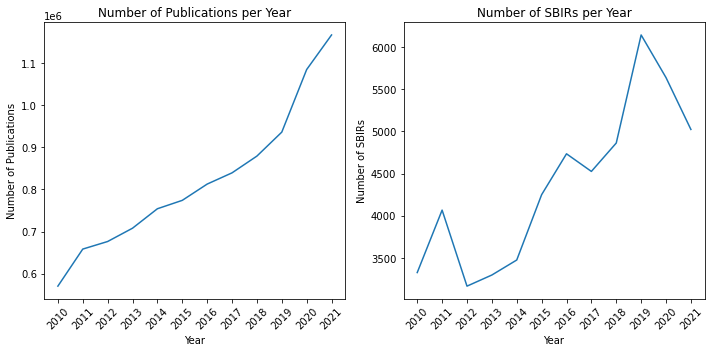

In [42]:
total_pubs_per_year_freq = {}
for year in years:
    total_pubs_per_year_freq[year] = []
    for dui in pdui2pubfreq:
        total_pubs_per_year_freq[year] += pdui2pubfreq[dui][year]
    total_pubs_per_year_freq[year] = len(set(total_pubs_per_year_freq[year]))

total_sbirs_per_year_freq = {}
for year in years:
    total_sbirs_per_year_freq[year] = []
    for dui in pdui2sbfreq:
        total_sbirs_per_year_freq[year] += pdui2sbfreq[dui][year]
    total_sbirs_per_year_freq[year] = len(set(total_sbirs_per_year_freq[year]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_pubs_per_year_freq.keys(), total_pubs_per_year_freq.values())
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Publications')
axs[0].set_title('Number of Publications per Year')
axs[1].plot(total_sbirs_per_year_freq.keys(), total_sbirs_per_year_freq.values())
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of SBIRs')
axs[1].set_title('Number of SBIRs per Year')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

100%|██████████| 12/12 [00:00<00:00, 12.42it/s]


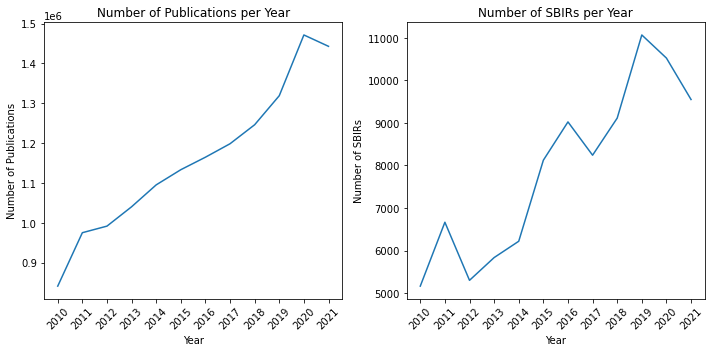

In [43]:
total_pubs_per_year_cit = {}
for year in tqdm(years):
    pmids_list = []
    for dui in pdui2pubcit:
        if pdui2pubfreq[dui][year] and pdui2pubcit[dui][year]:
            pmids_list += list(zip(pdui2pubfreq[dui][year], pdui2pubcit[dui][year]))
    pmids_set = set(pmids_list)
    # pmids_set = set([pmid for pmid in pmids_set if pmid[1] is not None])
    total_pubs_per_year_cit[year] = np.sum([impact_score for _, impact_score in pmids_set])

total_sbirs_per_year_cit = {}
for year in tqdm(years):
    sbids_list = []
    for dui in pdui2sbfreq:
        if pdui2sbfreq[dui][year] and pdui2sbcit[dui][year]:
            sbids_list += list(zip(pdui2sbfreq[dui][year], pdui2sbcit[dui][year]))
    sbids_set = set(sbids_list)
    # sbids_set = set([sbid for sbid in sbids_set if sbid[1] is not None])
    total_sbirs_per_year_cit[year] = np.sum([impact_score for _, impact_score in sbids_set])


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_pubs_per_year_cit.keys(), total_pubs_per_year_cit.values())
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Publications')
axs[0].set_title('Number of Publications per Year')
axs[1].plot(total_sbirs_per_year_cit.keys(), total_sbirs_per_year_cit.values())
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of SBIRs')
axs[1].set_title('Number of SBIRs per Year')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [45]:
dui2pubFreqSigProp = {}
dui2sbFreqSigProp = {}
dui2pubCitSigProp = {}
dui2sbCitSigProp = {}
for dui in tqdm(mutual_pairs):
        if dui2pubFreqSig[dui][i] and dui2sbFreqSig[dui][i] and dui2pubCitSig[dui][i] and dui2sbCitSig[dui][i]:
            dui2pubFreqSigProp[dui] = []
            dui2sbFreqSigProp[dui] = []
            dui2pubCitSigProp[dui] = []
            dui2sbCitSigProp[dui] = []
            for i in range(len(years)):
                dui2pubFreqSigProp[dui].append(dui2pubFreqSig[dui][i] / total_pubs_per_year_freq[years[i]])
                dui2sbFreqSigProp[dui].append(dui2sbFreqSig[dui][i] / total_sbirs_per_year_freq[years[i]])
                dui2pubCitSigProp[dui].append(np.sum(dui2pubCitSig[dui][i]) / total_pubs_per_year_cit[year])
                dui2sbCitSigProp[dui].append(np.sum(dui2sbCitSig[dui][i]) / total_sbirs_per_year_cit[year])
print('len(dui2pubFreqSigProp):', len(dui2pubFreqSigProp))
print('len(dui2sbFreqSigProp):', len(dui2sbFreqSigProp))
print('len(dui2pubCitSigProp):', len(dui2pubCitSigProp))
print('len(dui2sbCitSigProp):', len(dui2sbCitSigProp))

  0%|          | 0/34752 [00:00<?, ?it/s]

100%|██████████| 34752/34752 [00:02<00:00, 16096.10it/s]

len(dui2pubFreqSigProp): 26027
len(dui2sbFreqSigProp): 26027
len(dui2pubCitSigProp): 26027
len(dui2sbCitSigProp): 26027


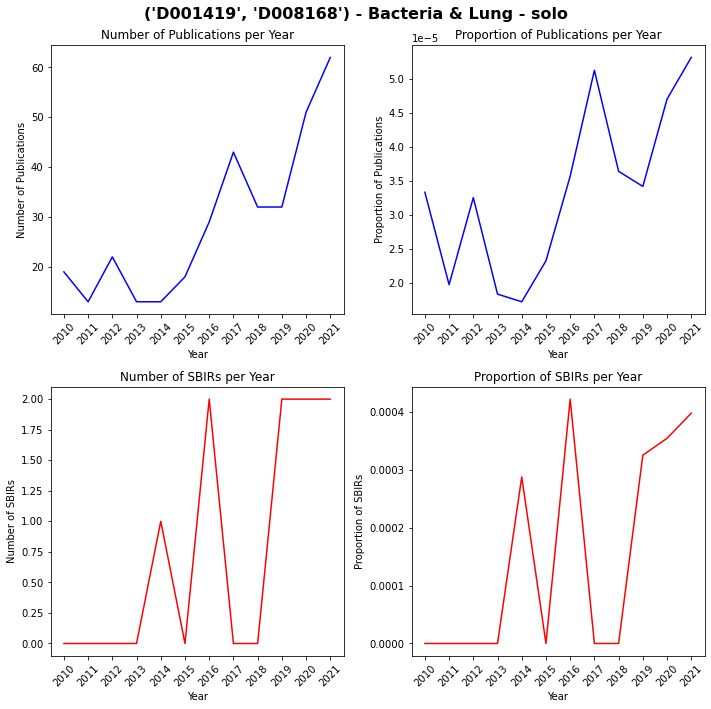

In [46]:
# now plot dui2pubFreqSig[sample_dui] and dui2pubFreqSigProp[sample_dui] next to each other. do the same for dui2sbFreqSig and dui2sbFreqSigProp with the same key as well. specify sbirs with red and publications with blue lines. make the font size of x axis and y axis and the title bigger.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_pair) + ' - ' + dui2name[sample_pair[0]] + ' & ' + dui2name[sample_pair[1]] + ' - solo', fontsize=16, fontweight='bold')
axs[0, 0].plot(years, dui2pubFreqSig[sample_pair], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years, dui2pubFreqSigProp[sample_pair], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Proportion of Publications per Year')
axs[1, 0].plot(years, dui2sbFreqSig[sample_pair], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years, dui2sbFreqSigProp[sample_pair], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

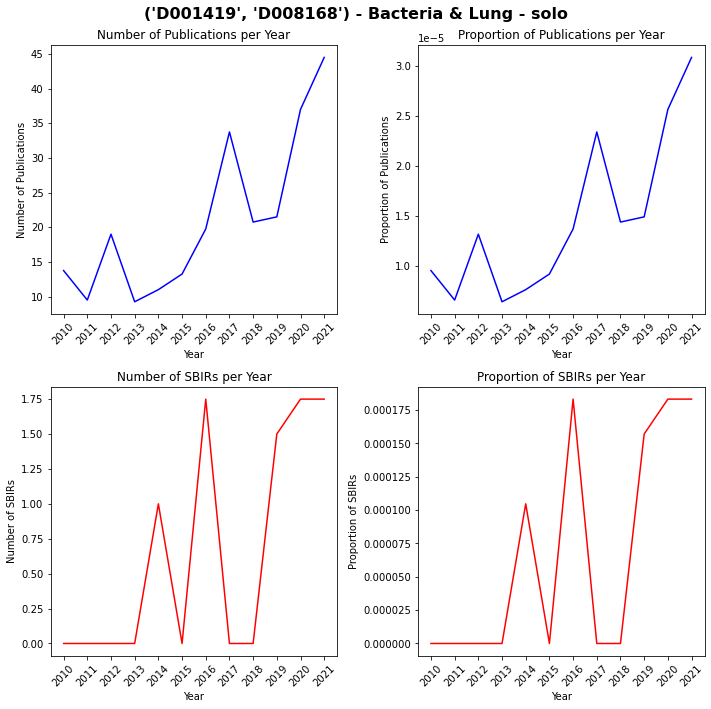

In [47]:
# now plot dui2pubFreqSig[sample_dui] and dui2pubFreqSigProp[sample_dui] next to each other. do the same for dui2sbFreqSig and dui2sbFreqSigProp with the same key as well. specify sbirs with red and publications with blue lines. make the font size of x axis and y axis and the title bigger.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_pair) + ' - ' + dui2name[sample_pair[0]] + ' & ' + dui2name[sample_pair[1]] + ' - solo', fontsize=16, fontweight='bold')
axs[0, 0].plot(years, dui2pubCitSig[sample_pair], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years, dui2pubCitSigProp[sample_pair], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Proportion of Publications per Year')
axs[1, 0].plot(years, dui2sbCitSig[sample_pair], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years, dui2sbCitSigProp[sample_pair], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [48]:
dui2pubFreqSigPropScaled = {}
dui2sbFreqSigPropScaled = {}
dui2pubCitSigPropScaled = {}
dui2sbCitSigPropScaled = {}
for dui in tqdm(dui2pubFreqSigProp):
    if dui2pubFreqSigProp[dui] and dui2sbFreqSigProp[dui] and dui2pubCitSigProp[dui] and dui2sbCitSigProp[dui]:
        dui2pubFreqSigPropScaled[dui] = []
        dui2sbFreqSigPropScaled[dui] = []
        dui2pubCitSigPropScaled[dui] = []
        dui2sbCitSigPropScaled[dui] = []
        for i in range(len(years)):
            try:
                dui2pubFreqSigPropScaled[dui].append((dui2pubFreqSigProp[dui][i] - min(dui2pubFreqSigProp[dui])) / (max(dui2pubFreqSigProp[dui]) - min(dui2pubFreqSigProp[dui])))
            except ZeroDivisionError:
                dui2pubFreqSigPropScaled[dui].append(0)
            try:
                dui2sbFreqSigPropScaled[dui].append((dui2sbFreqSigProp[dui][i] - min(dui2sbFreqSigProp[dui])) / (max(dui2sbFreqSigProp[dui]) - min(dui2sbFreqSigProp[dui])))
            except ZeroDivisionError:
                dui2sbFreqSigPropScaled[dui].append(0)
            try:
                dui2pubCitSigPropScaled[dui].append((dui2pubCitSigProp[dui][i] - min(dui2pubCitSigProp[dui])) / (max(dui2pubCitSigProp[dui]) - min(dui2pubCitSigProp[dui])))
            except ZeroDivisionError:
                dui2pubCitSigPropScaled[dui].append(0)
            try:
                dui2sbCitSigPropScaled[dui].append((dui2sbCitSigProp[dui][i] - min(dui2sbCitSigProp[dui])) / (max(dui2sbCitSigProp[dui]) - min(dui2sbCitSigProp[dui])))
            except ZeroDivisionError:
                dui2sbCitSigPropScaled[dui].append(0)
print('len(dui2pubFreqSigPropScaled):', len(dui2pubFreqSigPropScaled))
print('len(dui2sbFreqSigPropScaled):', len(dui2sbFreqSigPropScaled))
print('len(dui2pubCitSigPropScaled):', len(dui2pubCitSigPropScaled))
print('len(dui2sbCitSigPropScaled):', len(dui2sbCitSigPropScaled))

100%|██████████| 26027/26027 [00:01<00:00, 18458.88it/s]

len(dui2pubFreqSigPropScaled): 26027
len(dui2sbFreqSigPropScaled): 26027
len(dui2pubCitSigPropScaled): 26027
len(dui2sbCitSigPropScaled): 26027


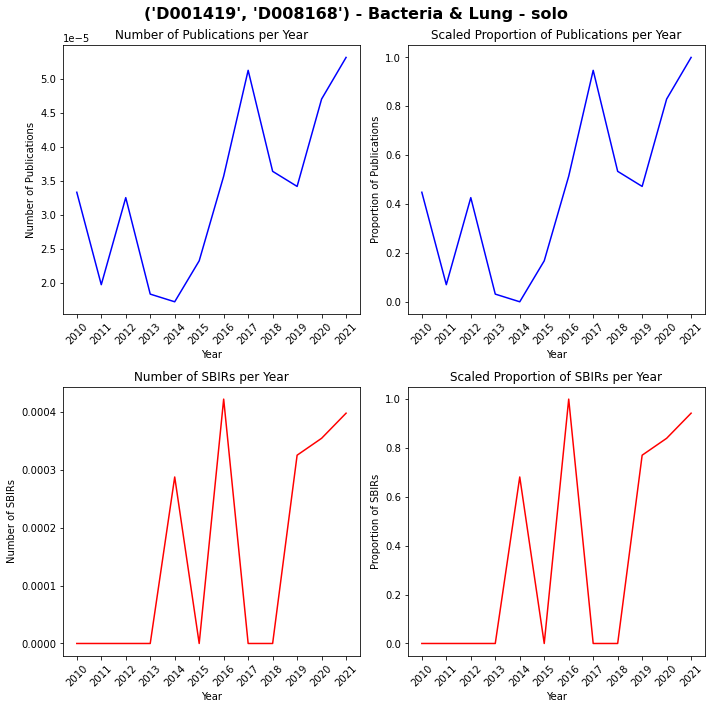

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_pair) + ' - ' + dui2name[sample_pair[0]] + ' & ' + dui2name[sample_pair[1]] + ' - solo', fontsize=16, fontweight='bold')
axs[0, 0].plot(years, dui2pubFreqSigProp[sample_pair], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years, dui2pubFreqSigPropScaled[sample_pair], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Scaled Proportion of Publications per Year')
axs[1, 0].plot(years, dui2sbFreqSigProp[sample_pair], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years, dui2sbFreqSigPropScaled[sample_pair], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Scaled Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

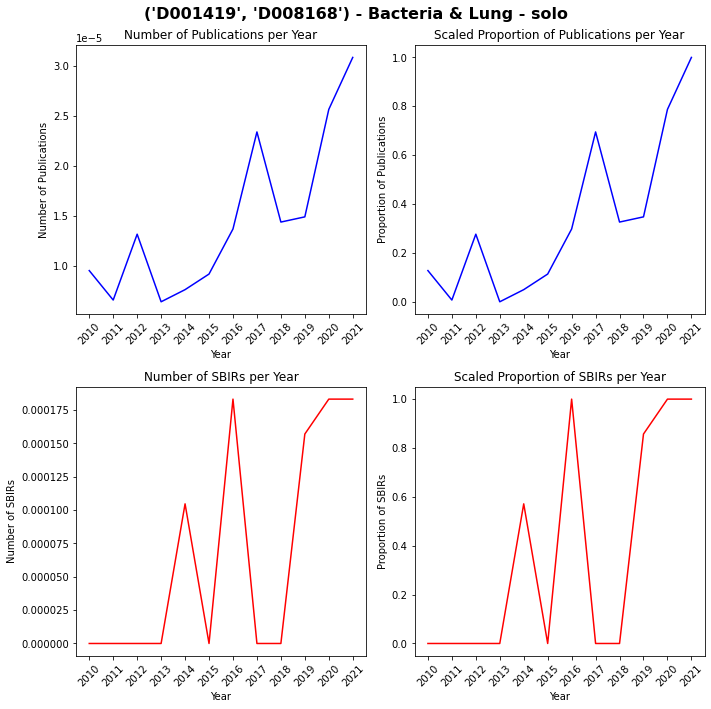

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_pair) + ' - ' + dui2name[sample_pair[0]] + ' & ' + dui2name[sample_pair[1]] + ' - solo', fontsize=16, fontweight='bold')
axs[0, 0].plot(years, dui2pubCitSigProp[sample_pair], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years, dui2pubCitSigPropScaled[sample_pair], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Scaled Proportion of Publications per Year')
axs[1, 0].plot(years, dui2sbCitSigProp[sample_pair], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years, dui2sbCitSigPropScaled[sample_pair], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Scaled Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [51]:
#save dui2prubFreqSigPropScaledchild and dui2sbFreqSigPropScaledchild to pickle at data/pickles/
with open('../data/pickles/pdui2pubFreqSigPropScaled.pickle', 'wb') as handle:
    pickle.dump(dui2pubFreqSigPropScaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/pdui2sbFreqSigPropScaled.pickle', 'wb') as handle:
    pickle.dump(dui2sbFreqSigPropScaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/pdui2pubCitSigPropScaled.pickle', 'wb') as handle:
    pickle.dump(dui2pubCitSigPropScaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/pdui2sbCitSigPropScaled.pickle', 'wb') as handle:
    pickle.dump(dui2sbCitSigPropScaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved')

Saved


In [52]:
#load dui2prubFreqSigPropScaledchild and dui2sbFreqSigPropScaledchild from pickle at data/pickles/
with open('../data/pickles/pdui2pubFreqSigPropScaled.pickle', 'rb') as handle:
    dui2pubFreqSigPropScaled = pickle.load(handle)
with open('../data/pickles/pdui2sbFreqSigPropScaled.pickle', 'rb') as handle:
    dui2sbFreqSigPropScaled = pickle.load(handle)
with open('../data/pickles/pdui2pubCitSigPropScaled.pickle', 'rb') as handle:
    dui2pubCitSigPropScaled = pickle.load(handle)
with open('../data/pickles/pdui2sbCitSigPropScaled.pickle', 'rb') as handle:
    dui2sbCitSigPropScaled = pickle.load(handle)
print('pdui2pubFreqSigPropScaled:', len(dui2pubFreqSigPropScaled))
print('pdui2sbFreqSigPropScaled:', len(dui2sbFreqSigPropScaled))
print('pdui2pubCitSigPropScaled:', len(dui2pubCitSigPropScaled))
print('pdui2sbCitSigPropScaled:', len(dui2sbCitSigPropScaled))

pdui2pubFreqSigPropScaled: 26027
pdui2sbFreqSigPropScaled: 26027
pdui2pubCitSigPropScaled: 26027
pdui2sbCitSigPropScaled: 26027


Cross-correlation

In [56]:
from scipy import signal

# create a dui2cc dictionary that maps a dui to a scipy cross correlation between the scaled pub and sbir frequencies
dui2cc_freq = {}
dui2cc_cit = {}
for dui in tqdm(dui2pubFreqSigPropScaled):
    sigA, sigB = dui2pubFreqSigPropScaled[dui], dui2sbFreqSigPropScaled[dui]
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2cc_freq[dui] = corr

    sigA, sigB = dui2pubCitSigPropScaled[dui], dui2sbCitSigPropScaled[dui]
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2cc_cit[dui] = corr

#save the dui2cc and dui2ccchild dictionaries in data/pickle
with open('../data/pickles/pdui2cc_freq.pickle', 'wb') as handle:
    pickle.dump(dui2cc_freq, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/pdui2cc_cit.pickle', 'wb') as handle:
    pickle.dump(dui2cc_cit, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Saved')
print('len(dui2cc_freq):', len(dui2cc_freq))
print('len(dui2cc_cit):', len(dui2cc_cit))

100%|██████████| 26027/26027 [00:01<00:00, 23686.64it/s]


Saved
len(dui2cc_freq): 26027
len(dui2cc_cit): 26027


In [57]:
with open('../data/pickles/pdui2cc_freq.pickle', 'rb') as handle:
    dui2cc_freq = pickle.load(handle)
with open('../data/pickles/pdui2cc_cit.pickle', 'rb') as handle:
    dui2cc_cit = pickle.load(handle)
print('Loaded dui2cc_freq.', len(dui2cc_freq))
print('Loaded dui2cc_cit.', len(dui2cc_cit))

Loaded dui2cc_freq. 26027
Loaded dui2cc_cit. 26027


maximum_correlation_lag: -1
pos_auc: 4.071187806233214
neg_auc: 3.0720519658529826


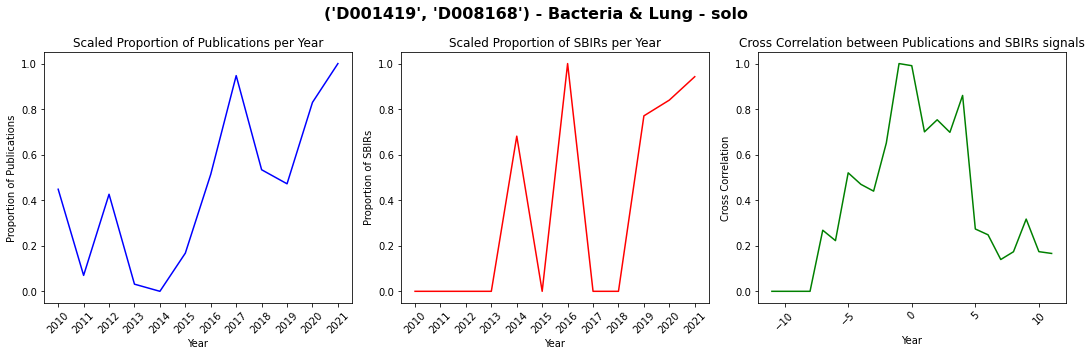

In [58]:
# plot three plots next to each other, one for dui2pubFreqSigPropScaled, one for dui2sbFreqSigPropScaled, and one for dui2ccdui2cc
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(str(sample_pair) + ' - ' + dui2name[sample_pair[0]] + ' & ' + dui2name[sample_pair[1]] + ' - solo', fontsize=16, fontweight='bold')
axs[0].plot(years, dui2pubFreqSigPropScaled[sample_pair], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Proportion of Publications')
axs[0].set_title('Scaled Proportion of Publications per Year')
axs[1].plot(years, dui2sbFreqSigPropScaled[sample_pair], color='red')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Proportion of SBIRs')
axs[1].set_title('Scaled Proportion of SBIRs per Year')
axs[2].plot(correlation_lags, dui2cc_freq[sample_pair], color='green')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Cross Correlation')
axs[2].set_title('Cross Correlation between Publications and SBIRs signals')

# calculate the maximum correlation lag
maximum_correlation_lag = correlation_lags[np.argmax(dui2cc_freq[sample_pair])]
print('maximum_correlation_lag:', maximum_correlation_lag)
#calcualte the AUC of the cross-correlation signal
zero_index = correlation_lags.index(0)
pos_auc = np.trapz(dui2cc_freq[sample_pair][zero_index + 1:], dx=1)
neg_auc = np.trapz(dui2cc_freq[sample_pair][:zero_index], dx=1)
print('pos_auc:', pos_auc)
print('neg_auc:', neg_auc)

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

maximum_correlation_lag: -1
pos_auc: 2.823553751801204
neg_auc: 2.6735329518713096


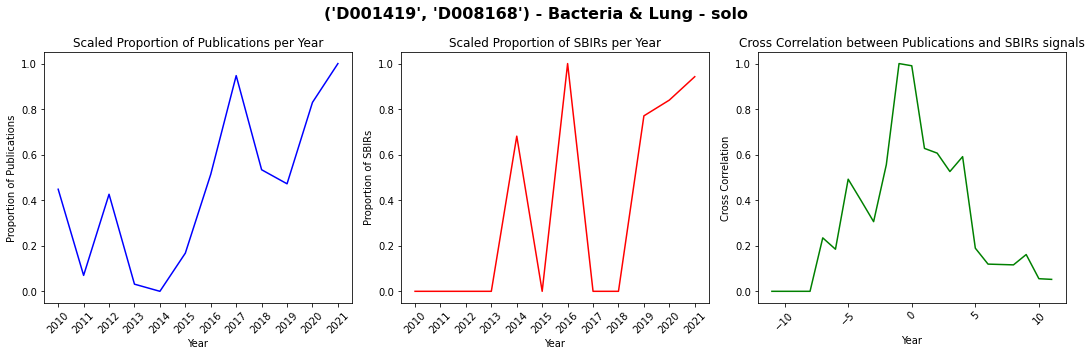

In [59]:
# plot three plots next to each other, one for dui2pubFreqSigPropScaled, one for dui2sbFreqSigPropScaled, and one for dui2cc_cit
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(str(sample_pair) + ' - ' + dui2name[sample_pair[0]] + ' & ' + dui2name[sample_pair[1]] + ' - solo', fontsize=16, fontweight='bold')
axs[0].plot(years, dui2pubFreqSigPropScaled[sample_pair], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Proportion of Publications')
axs[0].set_title('Scaled Proportion of Publications per Year')
axs[1].plot(years, dui2sbFreqSigPropScaled[sample_pair], color='red')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Proportion of SBIRs')
axs[1].set_title('Scaled Proportion of SBIRs per Year')
axs[2].plot(correlation_lags, dui2cc_cit[sample_pair], color='green')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Cross Correlation')
axs[2].set_title('Cross Correlation between Publications and SBIRs signals')

# calculate the maximum correlation lag
maximum_correlation_lag = correlation_lags[np.argmax(dui2cc_cit[sample_pair])]
print('maximum_correlation_lag:', maximum_correlation_lag)
#calcualte the AUC of the cross-correlation signal
zero_index = correlation_lags.index(0)
pos_auc = np.trapz(dui2cc_cit[sample_pair][zero_index + 1:], dx=1)
neg_auc = np.trapz(dui2cc_cit[sample_pair][:zero_index], dx=1)
print('pos_auc:', pos_auc)
print('neg_auc:', neg_auc)

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [60]:
# create dui2mcclag and dui2mcclagchild
dui2mcclag_freq = {}
dui2aucratio_freq = {}
dui2mcclag_cit = {}
dui2aucratio_cit = {}

for dui in tqdm(dui2cc_freq):
    dui2mcclag_freq[dui] = correlation_lags[np.argmax(dui2cc_freq[dui])]    
for dui in tqdm(dui2cc_freq):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2cc_freq[dui][zero_index + 1:], dx=1)
    neg_auc = np.trapz(dui2cc_freq[dui][:zero_index], dx=1)
    dui2aucratio_freq[dui] = (pos_auc + 1) / (neg_auc + 1)

for dui in tqdm(dui2cc_cit):
    dui2mcclag_cit[dui] = correlation_lags[np.argmax(dui2cc_cit[dui])]
for dui in tqdm(dui2cc_cit):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2cc_cit[dui][zero_index + 1:], dx=1)
    neg_auc = np.trapz(dui2cc_cit[dui][:zero_index], dx=1)
    dui2aucratio_cit[dui] = (pos_auc + 1) / (neg_auc + 1)

with open('../data/pickles/dui2mcclag_freq.pickle', 'wb') as handle:
    pickle.dump(dui2mcclag_freq, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/dui2aucratio_freq.pickle', 'wb') as handle:
    pickle.dump(dui2aucratio_freq, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/dui2mcclag_cit.pickle', 'wb') as handle:
    pickle.dump(dui2mcclag_cit, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickles/dui2aucratio_cit.pickle', 'wb') as handle:
    pickle.dump(dui2aucratio_cit, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('len(dui2mcclag_freq):', len(dui2mcclag_freq))
print('len(dui2aucratio_freq):', len(dui2aucratio_freq))
print('len(dui2mcclag_cit):', len(dui2mcclag_cit))
print('len(dui2aucratio_cit):', len(dui2aucratio_cit))

100%|██████████| 26027/26027 [00:00<00:00, 90703.53it/s]


len(dui2mcclag_freq): 26027
len(dui2aucratio_freq): 26027
len(dui2mcclag_cit): 26027
len(dui2aucratio_cit): 26027


In [61]:
# load dui2mcclag and dui2mcclagchild from data/pickle
with open('../data/pickles/dui2mcclag_freq.pickle', 'rb') as handle:
    dui2mcclag_freq = pickle.load(handle)
with open('../data/pickles/dui2aucratio_freq.pickle', 'rb') as handle:
    dui2aucratio_freq = pickle.load(handle)
with open('../data/pickles/dui2mcclag_cit.pickle', 'rb') as handle:
    dui2mcclag_cit = pickle.load(handle)
with open('../data/pickles/dui2aucratio_cit.pickle', 'rb') as handle:
    dui2aucratio_cit = pickle.load(handle)

print('len(dui2mcclag):', len(dui2mcclag_freq))
print('len(dui2aucratio):', len(dui2aucratio_freq))
print('len(dui2mcclag):', len(dui2mcclag_cit))
print('len(dui2aucratio):', len(dui2aucratio_cit))

len(dui2mcclag): 26027
len(dui2aucratio): 26027
len(dui2mcclag): 26027
len(dui2aucratio): 26027


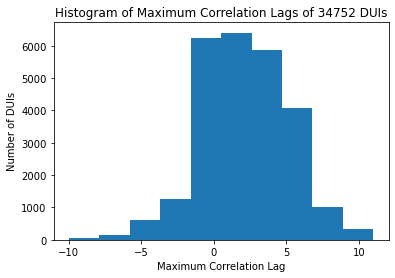

In [66]:
# create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2mcclag_freq[pair] for pair in dui2mcclag_freq]
plt.hist(dui_subset_mcclags, bins=10)
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(mutual_pairs)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

neg: 4556
zero: 0
pos: 21471


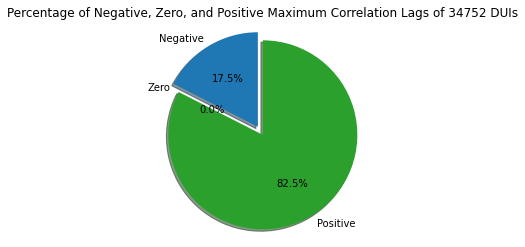

In [67]:
#return the percentage of negative, zero, and positive maximum correlation lags as a circle graph
dui_subset_mcclags = [dui2aucratio_freq[pair] for pair in dui2aucratio_freq]
neg = len([lag for lag in dui_subset_mcclags if lag < 1])
zero = len([lag for lag in dui_subset_mcclags if lag == 1])
pos = len([lag for lag in dui_subset_mcclags if lag > 1])
print('neg:', neg)
print('zero:', zero)
print('pos:', pos)

labels = 'Negative', 'Zero', 'Positive'
sizes = [neg, zero, pos]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(mutual_pairs)) + ' DUIs')
plt.show()

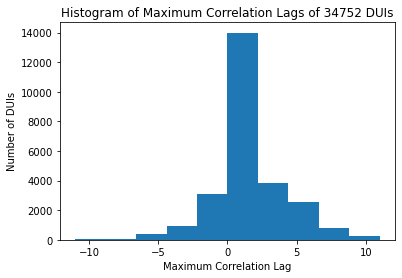

In [68]:
# create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2mcclag_cit[pair] for pair in dui2mcclag_cit]
plt.hist(dui_subset_mcclags, bins=10)
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(mutual_pairs)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

neg: 6248
zero: 0
pos: 19779


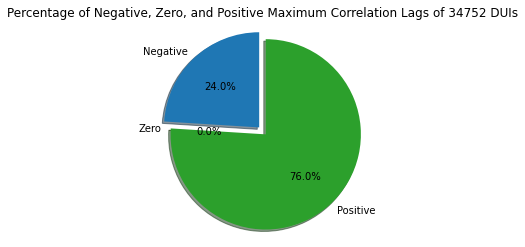

In [69]:
#return the percentage of negative, zero, and positive maximum correlation lags as a circle graph
dui_subset_mcclags = [dui2aucratio_cit[pair] for pair in dui2aucratio_cit]
neg = len([lag for lag in dui_subset_mcclags if lag < 1])
zero = len([lag for lag in dui_subset_mcclags if lag == 1])
pos = len([lag for lag in dui_subset_mcclags if lag > 1])
print('neg:', neg)
print('zero:', zero)
print('pos:', pos)

labels = 'Negative', 'Zero', 'Positive'
sizes = [neg, zero, pos]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(mutual_pairs)) + ' DUIs')
plt.show()

In [4]:
#read 'data/pubmed_dataset/pmid2emb2d.pkl'
with open('../data/pickles/pmid2emb2d.pkl', 'rb') as handle:
    pmid2emb2d = pickle.load(handle)
    print('pmid2emb2d:', len(pmid2emb2d))

#read 'data/pubmed_dataset/sbid2emb2d.pkl'
with open('../data/pickles/sbid2emb2d.pkl', 'rb') as handle:
    sbid2emb2d = pickle.load(handle)    
    print('sbid2emb2d:', len(sbid2emb2d))

pmid2emb2d: 10928078
sbid2emb2d: 63488


In [4]:
#all the imports
from sklearn.neighbors import KernelDensity
import scipy.stats as st
from math import log2

def calculate_jsd(p, q):
    m = 0.5 * (p + q)
    jsd = 0.5 * st.entropy(p, m) + 0.5 * st.entropy(q, m)
    return jsd

with open('../data/pubmed_dataset/pubmed_2pairs.pkl', 'rb') as f:
    pubmed_2pairs = pickle.load(f)
print('pubmed_2pairs:', len(pubmed_2pairs))
with open('../data/sbir_dataset/sbir_2pairs.pkl', 'rb') as f:
    sbir_2pairs = pickle.load(f)
print('sbir_2pairs:', len(sbir_2pairs))
with open('../data/pickles/mutual_pairs.pkl', 'rb') as f:
    mutual_pairs = pickle.load(f)
print('mutual_pairs:', len(mutual_pairs))
with open('../data/pickles/pmid2emb2d.pkl', 'rb') as handle:
    pmid2emb2d = pickle.load(handle)
    print('pmid2emb2d:', len(pmid2emb2d))
with open('../data/pickles/sbid2emb2d.pkl', 'rb') as handle:
    sbid2emb2d = pickle.load(handle)    
    print('sbid2emb2d:', len(sbid2emb2d))
with open('../data/pickles/pdui2pubfreq.pkl', 'rb') as f:
    pdui2pubfreq = pickle.load(f)
with open('../data/pickles/pdui2sbfreq.pkl', 'rb') as f:
    pdui2sbfreq = pickle.load(f)
print('pdui2pubfreq:', len(pdui2pubfreq))
print('pdui2sbfreq:', len(pdui2sbfreq))
with open('../data/pickles/pdui2pubcit.pkl', 'rb') as handle:
    pdui2pubcit = pickle.load(handle)
with open('../data/pickles/pdui2sbcit.pkl', 'rb') as handle:
    pdui2sbcit = pickle.load(handle)

print('Loaded pdui2pubcit.pkl', len(pdui2pubcit))
print('Loaded pdui2sbcit.pkl', len(pdui2sbcit))

bin_sizes = np.array([20, 20]) #each dim will be discretized into 20 bins
kde_samples = np.array([[i, j] for i in range(bin_sizes[0]) for j in range(bin_sizes[1])])
all_pubmed_embs = np.array([list(each) for each in list(pmid2emb2d.values())])
all_sbir_embs = np.array([list(each) for each in list(sbid2emb2d.values())])
all_pubmed_embs.shape, all_sbir_embs.shape
all_embeddings = np.concatenate((all_pubmed_embs, all_sbir_embs))
min_general = np.min(all_embeddings, axis=0)
max_general = np.max(all_embeddings, axis=0)
all_embeddings.shape, min_general, max_general

pubmed_2pairs: 29129646
sbir_2pairs: 1455397
mutual_pairs: 34752
pmid2emb2d: 10928078
sbid2emb2d: 63488
pdui2pubfreq: 34752
pdui2sbfreq: 34752
Loaded pdui2pubcit.pkl 34752
Loaded pdui2sbcit.pkl 34752


((10991566, 2),
 array([-5.57435514, -4.74475388]),
 array([5.91685115, 5.87501581]))

In [5]:
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))

dui2parents: 29307


In [6]:
import os

already_processed = []
for filename in os.listdir(LAG_DATA_ADDRESS + 'parallel/TVDs/'):
    dui1, dui2 = filename.split('_')[0], filename.split('_')[1]
    already_processed.append((dui1, dui2))
already_processed = list(set(already_processed))
len(already_processed)

3151

In [7]:
from sklearn.neighbors import KernelDensity
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import gc

def process_dui(dui):
    if dui[0] not in dui2parents or dui[1] not in dui2parents:
        return
    parent1 = dui2parents[dui[0]][0]
    parent2 = dui2parents[dui[1]][0]
    if dui not in already_processed and parent1 != 'U000008' and parent1 != 'U000011' and parent2 != 'U000008' and parent2 != 'U000011':
        for ـ, pm_year in enumerate(years):
            for ـ, sb_year in enumerate(years):
                pmids = pdui2pubfreq[dui][pm_year]
                sbids = pdui2sbfreq[dui][sb_year]         

                if len(pmids) == 0 or len(sbids) == 0:
                    continue           

                #embed each pmid and sbid from pmids and sbids in a 2d space using the pmid2emb2d and sbid2emb2d dictionaries
                pm_embs = np.array([pmid2emb2d[pmid] for pmid in pmids])
                sb_embs = np.array([sbid2emb2d[sbid] for sbid in sbids])
                pm_impacts = pdui2pubcit[dui][pm_year]
                sb_impacts = pdui2sbcit[dui][sb_year]
                pm_embs_disc = np.floor((pm_embs - min_general) / (max_general - min_general) * (bin_sizes - 1)).astype(int)
                sb_embs_disc = np.floor((sb_embs - min_general) / (max_general - min_general) * (bin_sizes - 1)).astype(int)
                pm_bin_impact = np.zeros((bin_sizes[0], bin_sizes[1]))
                sb_bin_impact = np.zeros((bin_sizes[0], bin_sizes[1]))
                for i in range(len(pm_embs_disc)):
                    x, y = pm_embs_disc[i]
                    pm_bin_impact[x, y] += pm_impacts[i]
                for i in range(len(sb_embs_disc)):
                    x, y = sb_embs_disc[i]
                    sb_bin_impact[x, y] += sb_impacts[i]

                pm_probs = pm_bin_impact / np.sum(pm_bin_impact)
                pm_probs = pm_probs.flatten()
                sb_probs = sb_bin_impact / np.sum(sb_bin_impact)
                sb_probs = sb_probs.flatten()

                regularization_factor = 0.8
                pmkde = KernelDensity(bandwidth=regularization_factor).fit(pm_embs_disc, sample_weight=pm_impacts)
                pm_probs_kde = np.exp(pmkde.score_samples(kde_samples)).reshape(bin_sizes)
                pm_probs_kde = pm_probs_kde.flatten()

                sbkde = KernelDensity(bandwidth=regularization_factor).fit(sb_embs_disc, sample_weight=sb_impacts)
                sb_probs_kde = np.exp(sbkde.score_samples(kde_samples)).reshape(bin_sizes)
                sb_probs_kde = sb_probs_kde.flatten()

                tvd = 0.5 * np.sum(np.abs(pm_probs_kde - sb_probs_kde))
                jsd = calculate_jsd(pm_probs_kde, sb_probs_kde)
                hld = np.sqrt(0.5 * np.sum((np.sqrt(pm_probs_kde) - np.sqrt(sb_probs_kde)) ** 2))

                # save tvd jsd and hld as txt files that contain the scores for the dui. name the files as <dui>_<pm_year>_<sb_year>_TVD.txt, <dui>_<pm_year>_<sb_year>_JSD.txt, <dui>_<pm_year>_<sb_year>_HLD.txt in folder data/parallel/TVDs, data/parallel/JSDs, data/parallel/HLDs
                with open(LAG_DATA_ADDRESS + 'parallel/TVDs/' + dui[0] + '_' + dui[1] + '_' + str(pm_year) + '_' + str(sb_year) + '_TVD.txt', 'w') as f:
                    f.write(str(tvd))
                with open(LAG_DATA_ADDRESS + 'parallel/JSDs/' + dui[0] + '_' + dui[1] + '_' + str(pm_year) + '_' + str(sb_year) + '_JSD.txt', 'w') as f:
                    f.write(str(jsd))
                with open(LAG_DATA_ADDRESS + 'parallel/HLDs/' + dui[0] + '_' + dui[1] + '_' + str(pm_year) + '_' + str(sb_year) + '_HLD.txt', 'w') as f:
                    f.write(str(hld))

                fig, axs = plt.subplots(2, 2, figsize=(5, 5))  # Adjust the figsize according to your preference
                axs[0, 0].imshow(pm_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[0, 0].set_title('pm_probs')
                axs[0, 1].imshow(sb_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[0, 1].set_title('sb_probs')
                axs[1, 0].imshow(pm_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[1, 0].set_title('pm_probs_kde')
                axs[1, 1].imshow(sb_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[1, 1].set_title('sb_probs_kde')
                plt.tight_layout()  # Ensures proper spacing between subplots
                plt.savefig(LAG_DATA_ADDRESS + 'parallel/plots/{}_{}_{}_{}.png'.format(dui[0], dui[1], pm_year, sb_year))
                plt.close()

                del pm_embs, sb_embs, pm_impacts, sb_impacts, pm_embs_disc, sb_embs_disc, pm_bin_impact, sb_bin_impact, pm_probs, sb_probs, pm_probs_kde, sb_probs_kde, tvd, jsd, hld, fig, axs, pmkde, sbkde, regularization_factor, x, y

# Define the number of processes to match the number of CPU cores
num_processes = 120
# duis = mutual_pairs[len(already_processed) - 10:]
duis = list(pdui2pubcit.keys())

# Create a progress bar using tqdm
with tqdm(total=len(duis)) as pbar:
    # Create a pool of processes
    with Pool(processes=num_processes) as pool:
        # Map 'process_dui' to 'duis' using pool.map
        for _ in pool.imap_unordered(process_dui, duis):
            pbar.update(1)  # Update the progress bar

 21%|██        | 7333/34752 [08:16<2:05:32,  3.64it/s]

In [5]:
TVD_ADDRESS = 'parallel/TVDs/'
JSD_ADDRESS = 'parallel/JSDs/'
HLD_ADDRESS = 'parallel/HLDs/'

In [6]:
# tensor_TVD = np.ones((len(mutual_pairs), 12, 12))
# tensor_JSD = np.ones((len(mutual_pairs), 12, 12))
tensor_HLD = np.ones((len(mutual_pairs), 12, 12))

# tensor_TVD.shape, tensor_JSD.shape, tensor_HLD.shape
tensor_HLD.shape

(34752, 12, 12)

In [7]:
all_names = list(os.listdir('parallel/HLDs/'))
all_names[10:20]

['D003132_D012108_2019_2018_HLD.txt',
 'D000328_D019647_2013_2017_HLD.txt',
 'D009033_D014780_2012_2019_HLD.txt',
 'D000641_D005740_2015_2018_HLD.txt',
 'D000641_D006801_2011_2014_HLD.txt',
 'D001419_D004864_2012_2014_HLD.txt',
 'D000375_D051379_2015_2020_HLD.txt',
 'D000162_D011336_2013_2011_HLD.txt',
 'D002965_D012660_2010_2021_HLD.txt',
 'D010865_D014867_2011_2013_HLD.txt']

In [8]:
'D006801_D008928_2010_2010_HLD.txt' in all_names

False

In [9]:
# for each dui in exduis, load the corresponding TVD, JSD and HLD txt files and store them in the tensors
for i, dui in tqdm(enumerate(mutual_pairs)):
    for pm_year_idx, pm_year in enumerate(years):
        for sb_year_idx, sb_year in enumerate(years):
            try:
                # tensor_TVD[i, pm_year_idx, sb_year_idx] = np.loadtxt(TVD_ADDRESS + '{}_{}_{}_{}_TVD.txt'.format(dui[0], dui[1], pm_year, sb_year))
                # tensor_JSD[i, pm_year_idx, sb_year_idx] = np.loadtxt(JSD_ADDRESS + '{}_{}_{}_{}_JSD.txt'.format(dui[0], dui[1], pm_year, sb_year))
                tensor_HLD[i, pm_year_idx, sb_year_idx] = np.loadtxt(HLD_ADDRESS + '{}_{}_{}_{}_HLD.txt'.format(dui[0], dui[1], pm_year, sb_year))
            except OSError:
                pass
            except Exception as e:
                print(i, pm_year_idx, sb_year_idx, dui[0], dui[1], pm_year, sb_year)
                print(e, type(e))
                exit()

5041it [01:26, 58.80it/s]/tmp/ipykernel_49419/898345662.py:8: UserWarning: loadtxt: Empty input file: "parallel/HLDs/D013601_D014481_2016_2016_HLD.txt"
  tensor_HLD[i, pm_year_idx, sb_year_idx] = np.loadtxt(HLD_ADDRESS + '{}_{}_{}_{}_HLD.txt'.format(dui[0], dui[1], pm_year, sb_year))
5054it [01:26, 60.35it/s]

5042 6 6 D013601 D014481 2016 2016
setting an array element with a sequence. <class 'ValueError'>


34752it [09:49, 58.94it/s]


In [ ]:
#save the tensors in data/pickles
# with open('parallel/tensor_TVD.pkl', 'wb') as handle:
#     pickle.dump(tensor_TVD, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('parallel/tensor_JSD.pkl', 'wb') as handle:
#     pickle.dump(tensor_JSD, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('parallel/tensor_HLD.pkl', 'wb') as handle:
    pickle.dump(tensor_HLD, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tensors saved.')

: 

: 

In [ ]:
#load the tensors
with open('parallel/tensor_TVD.pkl', 'rb') as handle:
    TVD_diffs = pickle.load(handle)
with open('parallel/tensor_JSD.pkl', 'rb') as handle:
    JSD_diffs = pickle.load(handle)
with open('parallel/tensor_HLD.pkl', 'rb') as handle:
    HLD_diffs = pickle.load(handle)

TVD_diffs.shape, JSD_diffs.shape, HLD_diffs.shape

((34752, 12, 12), (34752, 12, 12), (34752, 12, 12))

In [ ]:
tensor_HLD[10]

In [ ]:
#turn distance-containing tensors into similarity-containing tensors
# tensor_TVD = 1 - TVD_diffs
# tensor_JSD = 1 - JSD_diffs
# tensor_HLD = 1 - HLD_diffs

# tensor_TVD.shape, tensor_JSD.shape, tensor_HLD.shape, np.min(tensor_TVD), np.max(tensor_TVD)

tensor_HLD = 1 - tensor_HLD
tensor_HLD.shape, np.min(tensor_HLD), np.max(tensor_HLD)

((34752, 12, 12), 0.0, 1.0)

In [ ]:
dui2tensoridx = {dui: i for i, dui in enumerate(mutual_pairs)}
tensoridx2dui = {i: dui for i, dui in enumerate(mutual_pairs)}

print('len(dui2tensoridx):', len(dui2tensoridx))
print('len(tensoridx2dui):', len(tensoridx2dui))

len(dui2tensoridx): 34752
len(tensoridx2dui): 34752


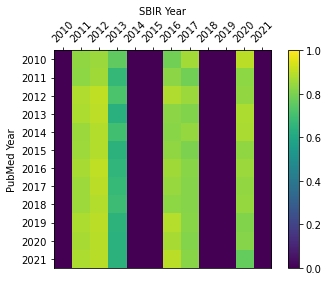

In [ ]:
plt.imshow(tensor_HLD[dui2tensoridx[mutual_pairs[0]]], vmin=0, vmax=1)
plt.colorbar()
plt.xticks(np.arange(12), years, rotation=45)
plt.yticks(np.arange(12), years)

ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.ylabel('PubMed Year')
plt.xlabel('SBIR Year')
plt.show()

In [ ]:
def cal_triangular_ratio(score_matrix):
    ps_sims = []
    sp_sims = []
    for i in range(score_matrix.shape[0]):
        for j in range(score_matrix.shape[1]):
            sim = score_matrix[i, j]
            if j > i:
                ps_sims.append(sim)
            else:
                sp_sims.append(sim)
    return (np.sum(ps_sims) + 1) / (np.sum(sp_sims) + 1)

sample = tensor_HLD[dui2tensoridx[mutual_pairs[0]]]
cal_triangular_ratio(sample)

0.6879547971166896

In [31]:
#calculate the triangular ratio for each dui
# dui2tvdtr = {}
dui2jsdtr = {}
# dui2hldtr = {}
for i in tqdm(range(len(tensor_TVD))):
    # dui2tvdtr[tensoridx2dui[i]] = cal_triangular_ratio(tensor_TVD[i])
    dui2jsdtr[tensoridx2dui[i]] = cal_triangular_ratio(tensor_JSD[i])
    # dui2hldtr[tensoridx2dui[i]] = cal_triangular_ratio(tensor_HLD[i])

# len(dui2tvdtr), len(dui2jsdtr), len(dui2hldtr)
len(dui2jsdtr)

100%|██████████| 34752/34752 [00:01<00:00, 32153.22it/s]


34752

len(dui_subset): 34752
neg: 8334 Ratio: 23.981353591159532
pos: 26418 Ratio: 76.0186464088376


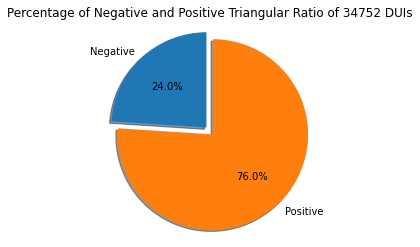

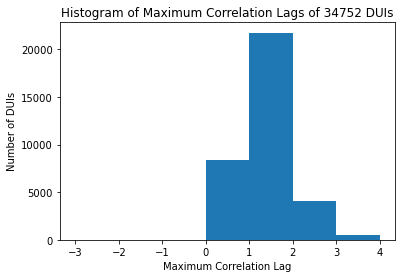

In [32]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2jsdtr[dui] for dui in mutual_pairs]
print('len(dui_subset):', len(dui_subset_mcclags))
neg = len([lag for lag in dui_subset_mcclags if lag <= 1])
pos = len([lag for lag in dui_subset_mcclags if lag > 1])
ppos = pos / (len(dui_subset_mcclags) + 0.000000001) * 100
pneg = neg / (len(dui_subset_mcclags) + 0.000000001) * 100

print('neg:', neg, 'Ratio:', pneg)
print('pos:', pos, 'Ratio:', ppos)

labels = 'Negative', 'Positive'
sizes = [neg, pos]
explode = (0.1, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative and Positive Triangular Ratio of ' + str(len(mutual_pairs)) + ' DUIs')
plt.show()

# plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -3 to 5 with 1 intervals
plt.hist(dui_subset_mcclags, bins=range(-3, 5, 1))
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(mutual_pairs)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

print('=' * 50)

In [2]:
auc_freq_pos, auc_freq_neg = 68.5, 31.5
auc_imp_pos, auc_imp_neg = 66.9, 33.1
auc_ratio_pos, auc_ratio_neg = 76, 24

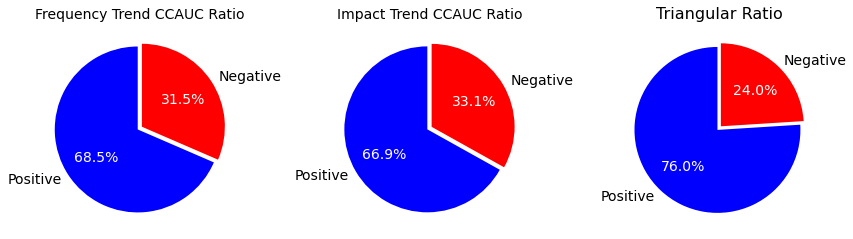

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
colors = ['royalblue', 'red']
explode = (0.03, 0.03)

# Pie plot for AUC Frequency
auc_freq_labels = ['Positive', 'Negative']
auc_freq_values = [auc_freq_pos, auc_freq_neg]
_, _, text1 = ax1.pie(auc_freq_values, labels=auc_freq_labels, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90,
                      textprops={'color': 'black', 'fontsize': 14})
ax1.set_title('Frequency Trend CCAUC Ratio', fontsize=14)

# Pie plot for AUC Impact
auc_imp_labels = ['Positive', 'Negative']
auc_imp_values = [auc_imp_pos, auc_imp_neg]
_, _, text2 = ax2.pie(auc_imp_values, labels=auc_imp_labels, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90,
                      textprops={'color': 'black', 'fontsize': 14})
ax2.set_title('Impact Trend CCAUC Ratio', fontsize=14)

# Pie plot for AUC Ratio
auc_ratio_labels = ['Positive', 'Negative']
auc_ratio_values = [auc_ratio_pos, auc_ratio_neg]
_, _, text3 = ax3.pie(auc_ratio_values, labels=auc_ratio_labels, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90,
                      textprops={'color': 'black', 'fontsize': 14})
ax3.set_title('Triangular Ratio', fontsize=16)

# Set the color of the percentages to black
for text in [text1, text2, text3]:
    text[0].set_color('white')
    text[1].set_color('white')

plt.tight_layout()
plt.savefig('pairs.png', dpi=300)
plt.show()